In [1]:
import os
import sys
os.environ["OMP_NUM_THREADS"] = "11"
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "11" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "11" # export NUMEXPR_NUM_THREADS=6
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse
import h5py

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
sns.set_theme()

from tqdm import tqdm

from compute_risk import *
from generate_data import *
from fixed_point_sol import *

import itertools

In [2]:
def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

# Ex1 Risk estimate

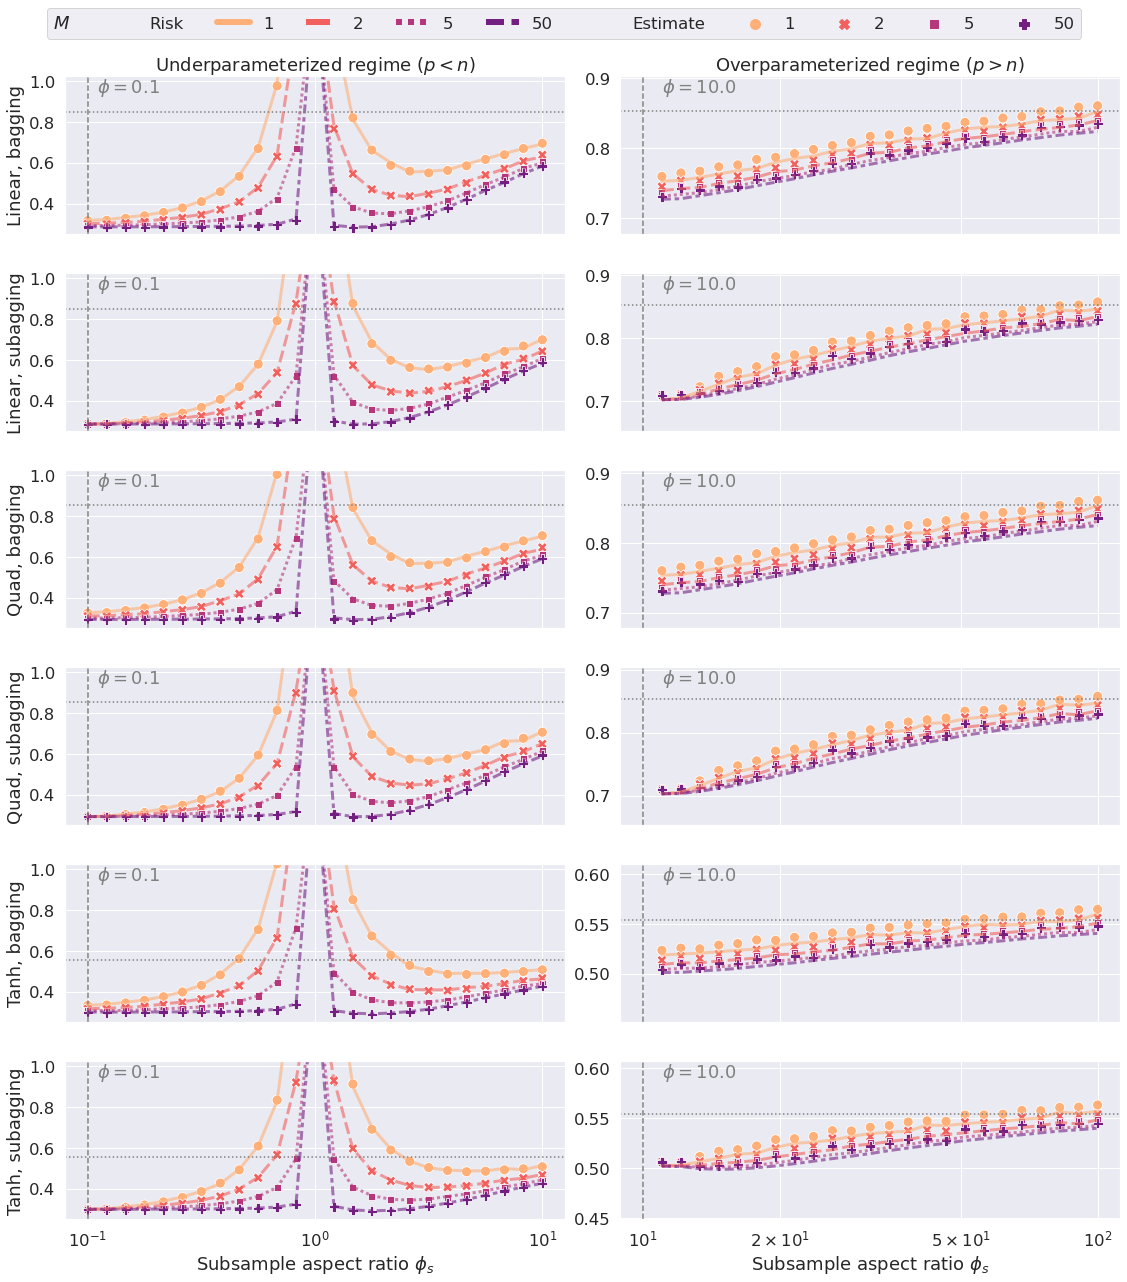

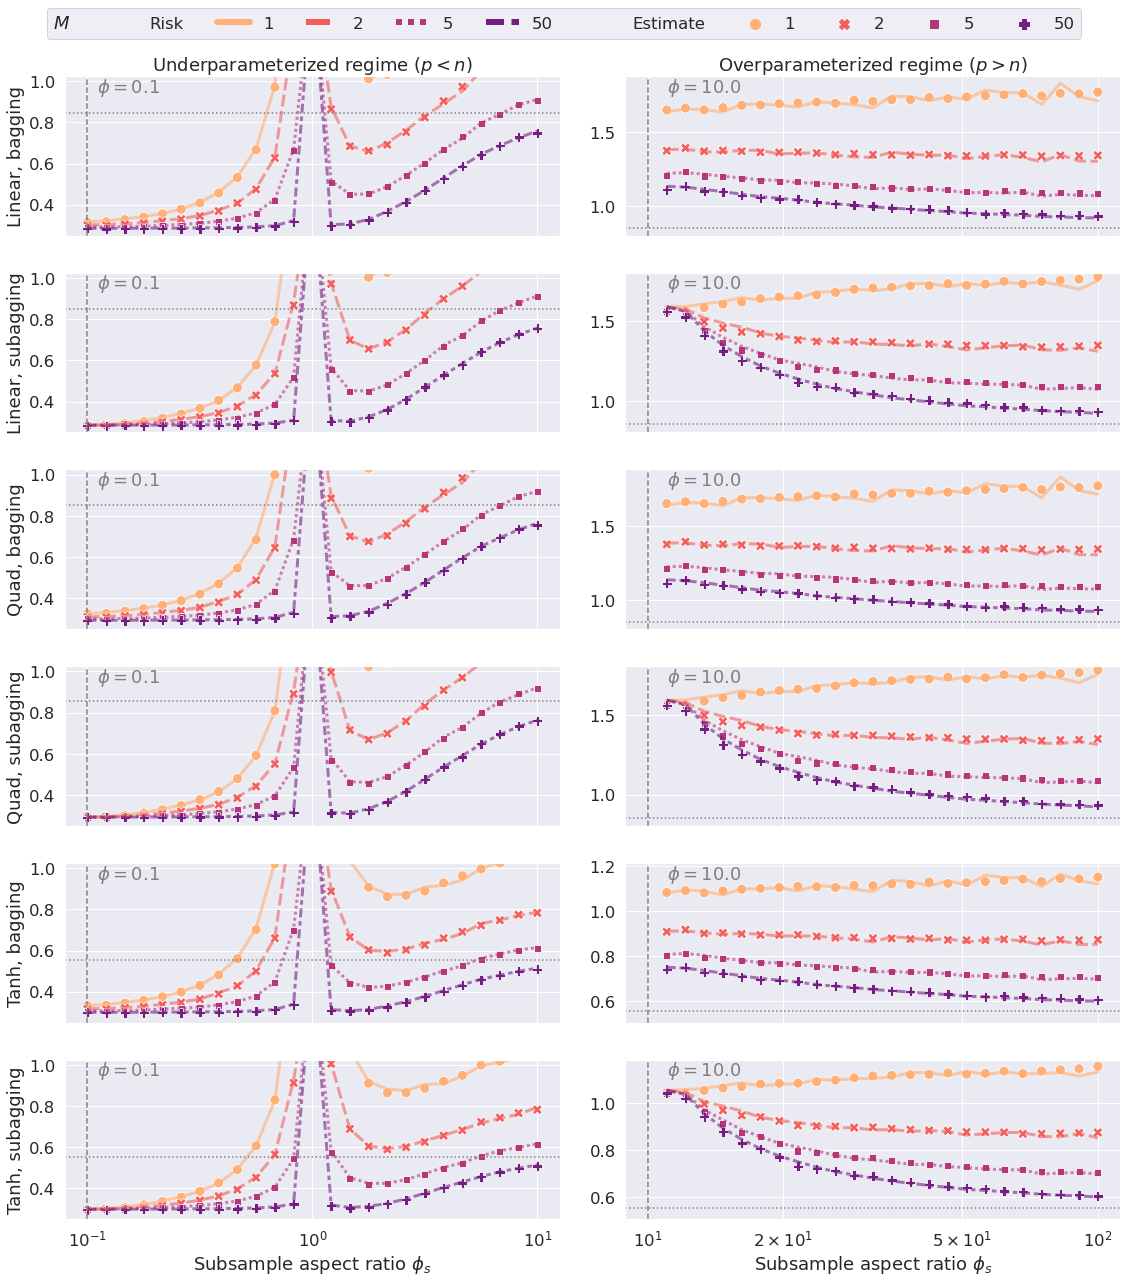

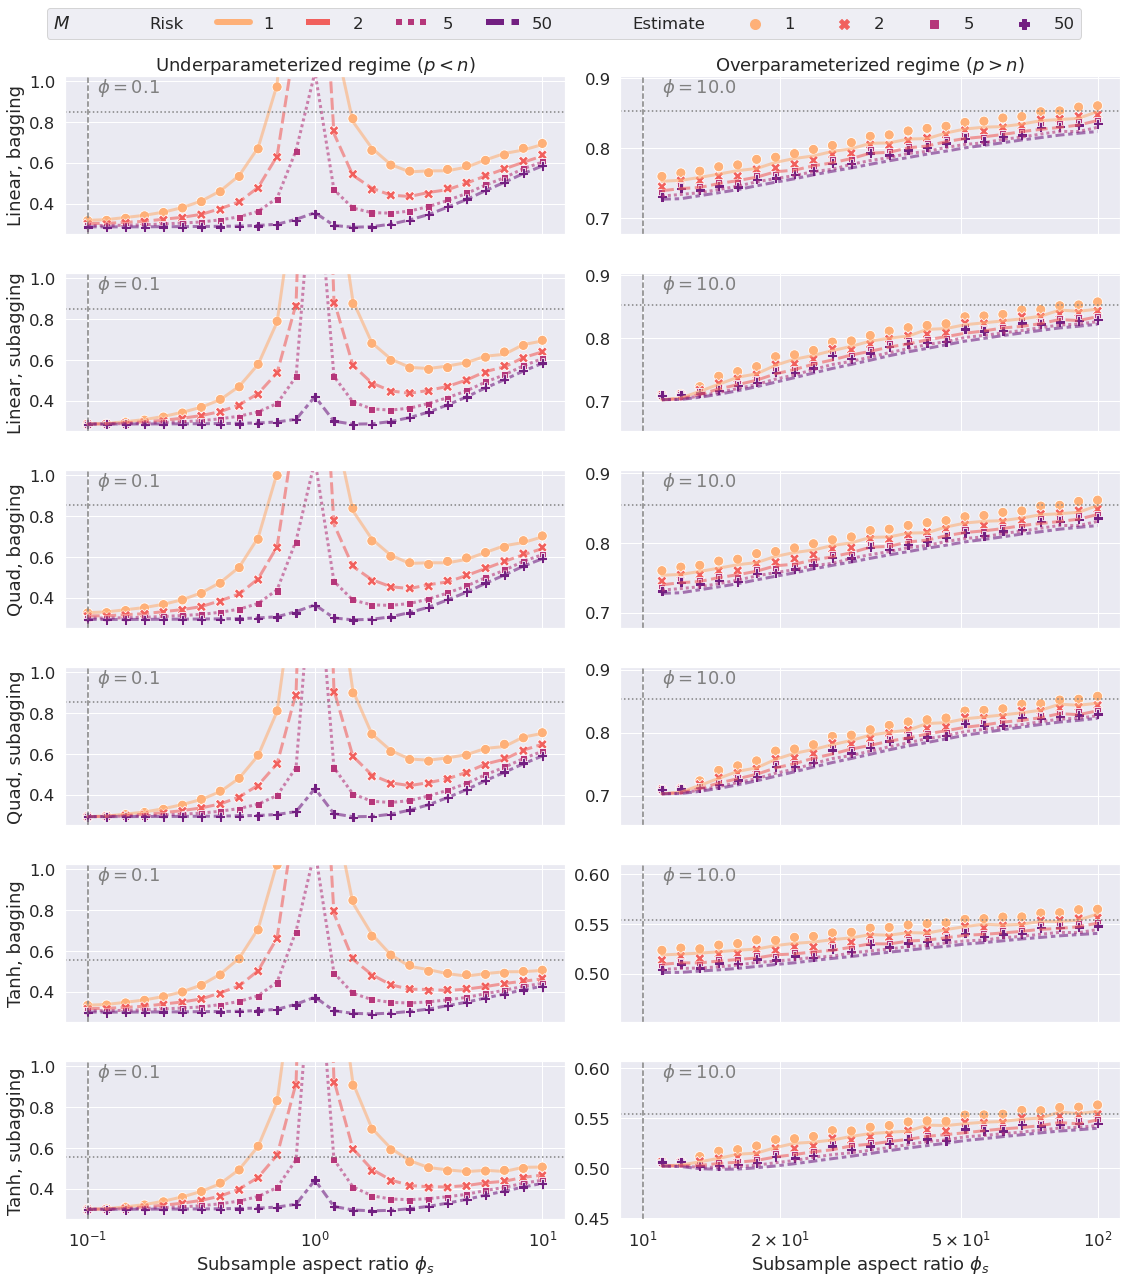

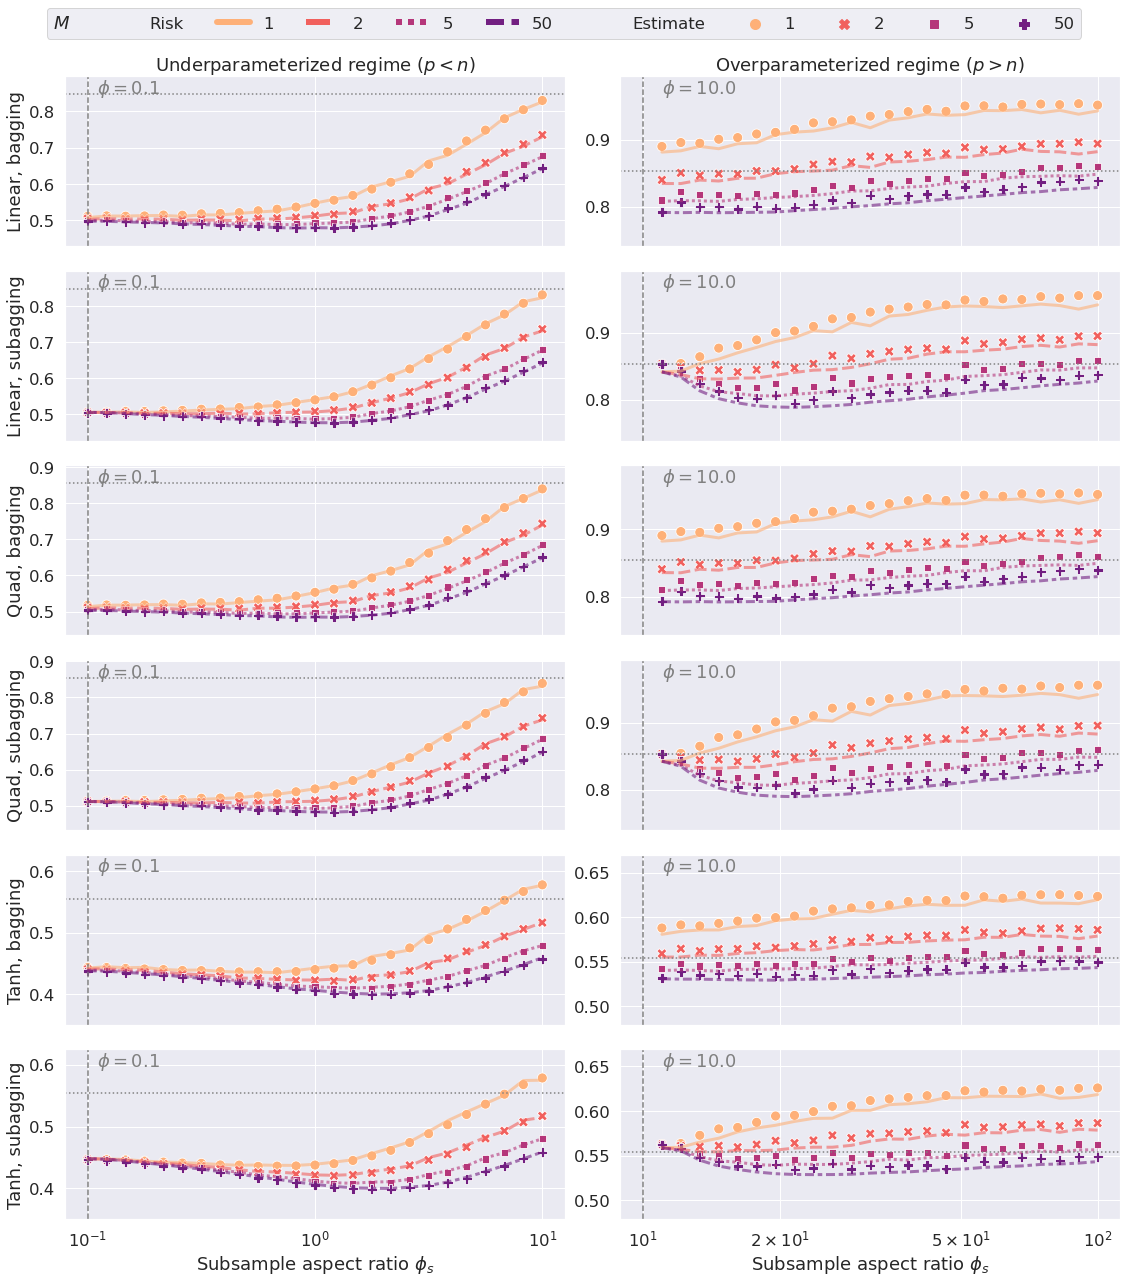

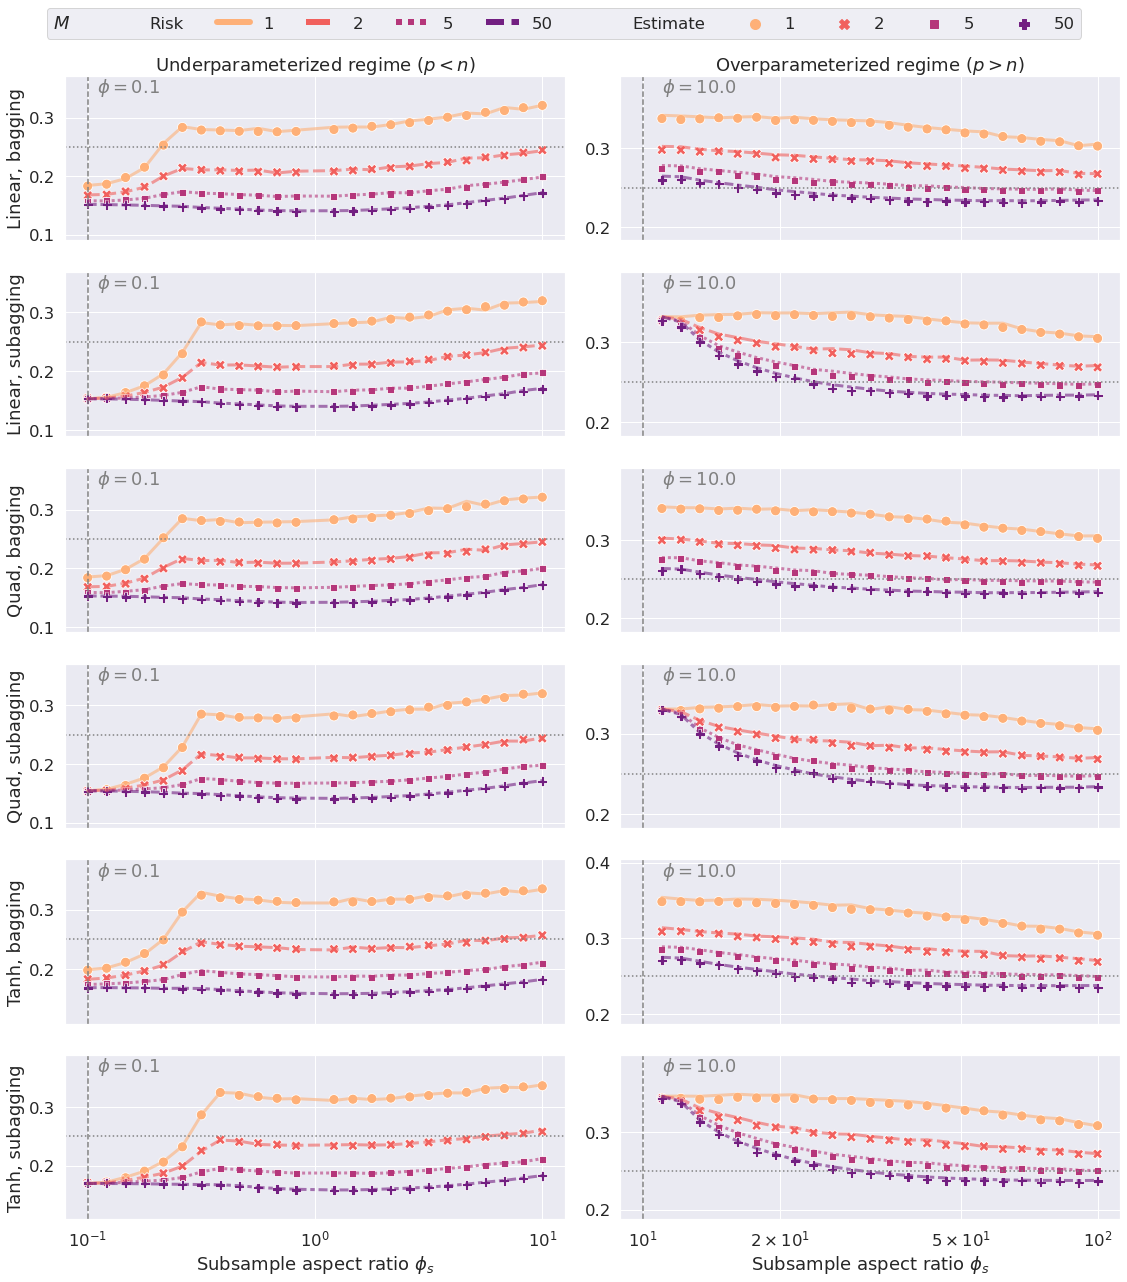

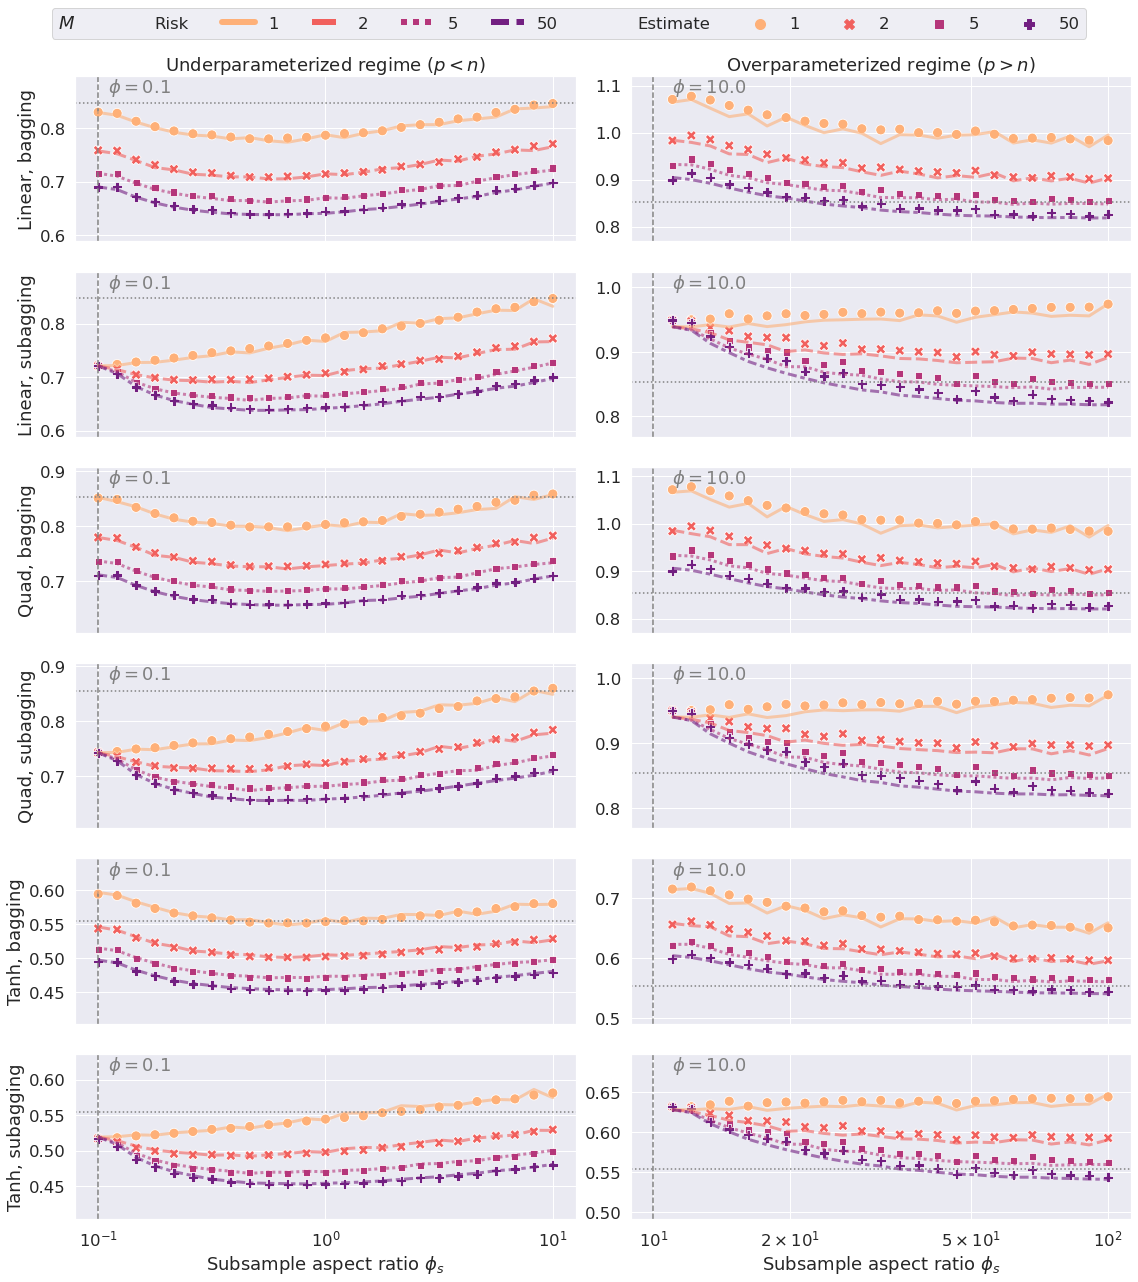

In [3]:
sns.set(font_scale=1.5)

M_list = np.array([1, 2, 5, 50])
M_str = M_list.astype(str)
hue_order = M_str
cm = sns.color_palette("magma_r", len(M_list)+1)
title_list = ['Underparameterized regime ($p<n$)',
              'Overparameterized regime ($p>n$)']

rho_ar1 = 0.5
sigma = .5
sigma2 = sigma**2
func_list = ['linear','quad', 'tanh']
bagging_list = ['bagging', 'subagging']
predictor_list = ['ridgeless', 'lassoless', 'ridge', 'lasso', 'logistic', 'kNN']
for predictor in predictor_list:
    fig, axes = plt.subplots(6,2, figsize=(16,18),
                             sharex='col', gridspec_kw={'width_ratios': [1, 1]})
    for i, (func, bagging) in enumerate(list(itertools.product(func_list, bagging_list))):
        file_name = 'result/ex1/res_{}_{}_{}.pkl'.format(func, bagging, predictor)
        df = pd.read_pickle(file_name, compression='gzip')
        df.columns = ['phi_s','seed', 'type']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist() + [
            r'risk-0', 'rhoar1', 'phi']
        df = pd.wide_to_long(df, stubnames='risk', i=['phi', 'rhoar1', 'phi_s', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
        df['M'] = df['M'].astype(int).astype(str)
        df.loc[df['M']=='0','M'] = '$\infty$'    
        df = df[df['M'].isin(M_str)]

        # interpolation point
        if predictor.endswith('less'):
            _df = df.groupby(['phi','rhoar1','M']).count().reset_index()
            _df = _df[_df['phi']<1]
            _df['phi_s'] = 1.
            _df['type'] = 'risk_emp'
            _df['risk'] = 1.5
            _df = _df[df.columns]
            df = pd.concat([df,_df], axis=0)
        df_res = df

        for j, phi in enumerate([0.1,10.]):
            idx = (df_res['phi']==phi) & (df_res['rhoar1']==rho_ar1)
            df_res_emp = df_res[(df_res['type']=='risk_emp')& idx ]
            df_res_oob = df_res[(df_res['type']=='oobcv_emp') & idx]
            df_null = df_res[(df_res['phi_s']==np.inf) & idx]
            
            if j==0 and (predictor.endswith('less') or predictor in ['ridge']):
                y_lims = [1.*sigma**2, 4.1*sigma**2]
            else:
                y_lims = [df_res_emp.groupby(['M','phi_s'])['risk'].mean().min()-0.05, df_res_emp.groupby(['M','phi_s'])['risk'].mean().max()+0.05]
            y_text_list = (y_lims[1]-y_lims[0]) * 0.9 + y_lims[0]

            axes[i,j].vlines(phi, y_lims[0], y_lims[1], linestyles='--', color='gray')
            axes[i,j].text(phi*1.1, y_text_list,'$\phi={:.01f}$'.format(phi), color='gray')
            
            
            null_risk = df_null[df_null['type']=='risk_emp']['risk'].values.mean().mean()

            sns.lineplot(data=df_res_emp[(df_res_emp['phi']==phi)&(df_res_emp['M'].isin(hue_order))], 
                         x='phi_s', y='risk', hue='M', style='M', ci=None, 
                     linestyle='-', linewidth=3, alpha=0.6, palette=cm[:len(np.unique(df_res_emp['M']))],
                    ax=axes[i,j])
            axes[i,j].set_title('Prediction risk')

            sns.scatterplot(data=df_res_oob[(df_res_oob['phi']==phi)&(df_res_oob['M'].isin(hue_order))].groupby(['phi_s','M','type']).mean(), 
                            x='phi_s', y='risk', hue='M', style='M',
                            s=100, palette=cm[:len(np.unique(df_res_oob['M']))],
                    ax=axes[i,j])
            if i==0:
                axes[i,j].set_title(title_list[j])
            else:
                axes[i,j].set_title('')
            if i==5:
                axes[i,j].set_xlabel('Subsample aspect ratio $\phi_s$')
            
            axes[i,j].axhline(null_risk, linestyle='dotted', color='gray')
            axes[i,j].set_xscale('log', base=10)
            axes[i,j].set_ylim(y_lims)

        axes[i,0].set_ylabel('{}, {}'.format(func.capitalize(), bagging))
        axes[i,1].set_ylabel('')

        axes[i,1].set_xticks([10, 20, 50, 100])
        axes[i,1].set_xticklabels(['$10^1$',r'$2\times 10^1$',r'$5\times 10^1$','$10^2$'])

    fig.tight_layout()

    lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,1]]]
    handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    for i in range(6):
        for j in range(2):
            axes[i,j].get_legend().remove()

    handles = np.r_[mlines.Line2D([], [], color='k', linestyle='None'), 
                    handles[:4], mlines.Line2D([], [], color='k', linestyle='None'), handles[-4:]].tolist()
    labels = np.concatenate([['Risk'], labels[:4], ['Estimate'], labels[-4:]]).tolist()
    legend = fig.legend(handles=handles, labels=labels,
                        loc=9, ncol=11, title='$M$')
    for i,(item, label) in enumerate(zip(legend.legendHandles, legend.texts)):
        if 0<i<5:
            item.set_linewidth(6)
        elif 5<i:
            item.set_sizes((100,))
    legend_title_left(legend)

    fig.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.savefig('result/fig_est_{}_{}.pdf'.format(rho_ar1,predictor),
                bbox_inches='tight', pad_inches=0, dpi=300,)

# Ex2 Risk CV

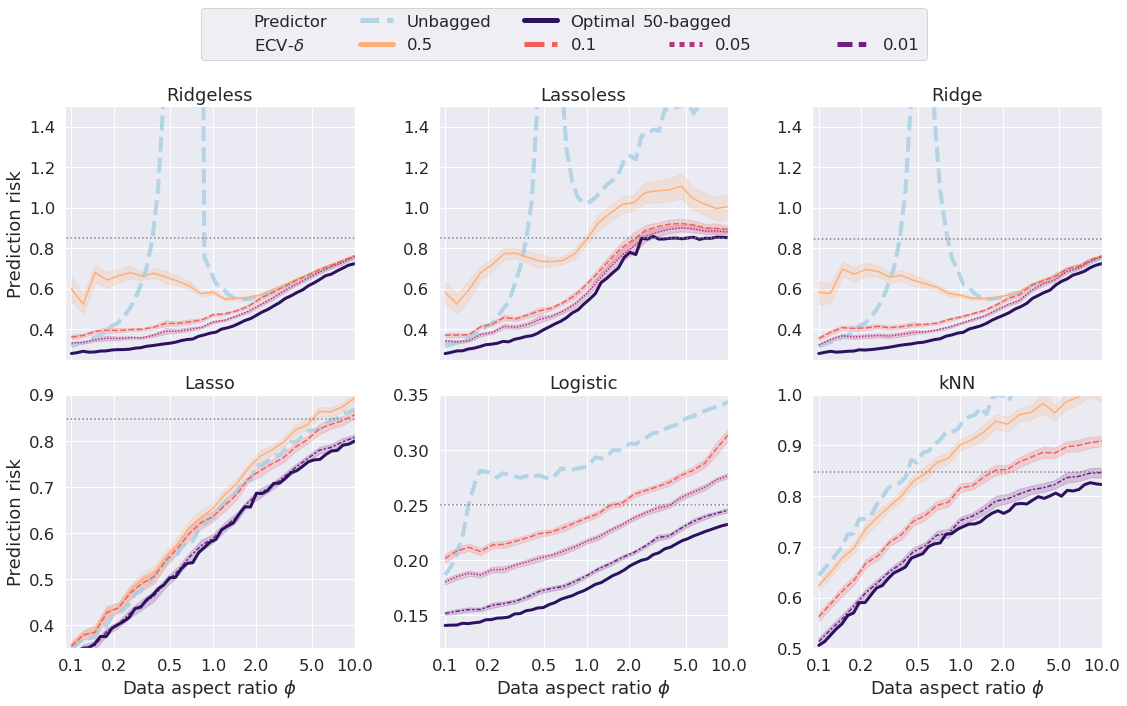

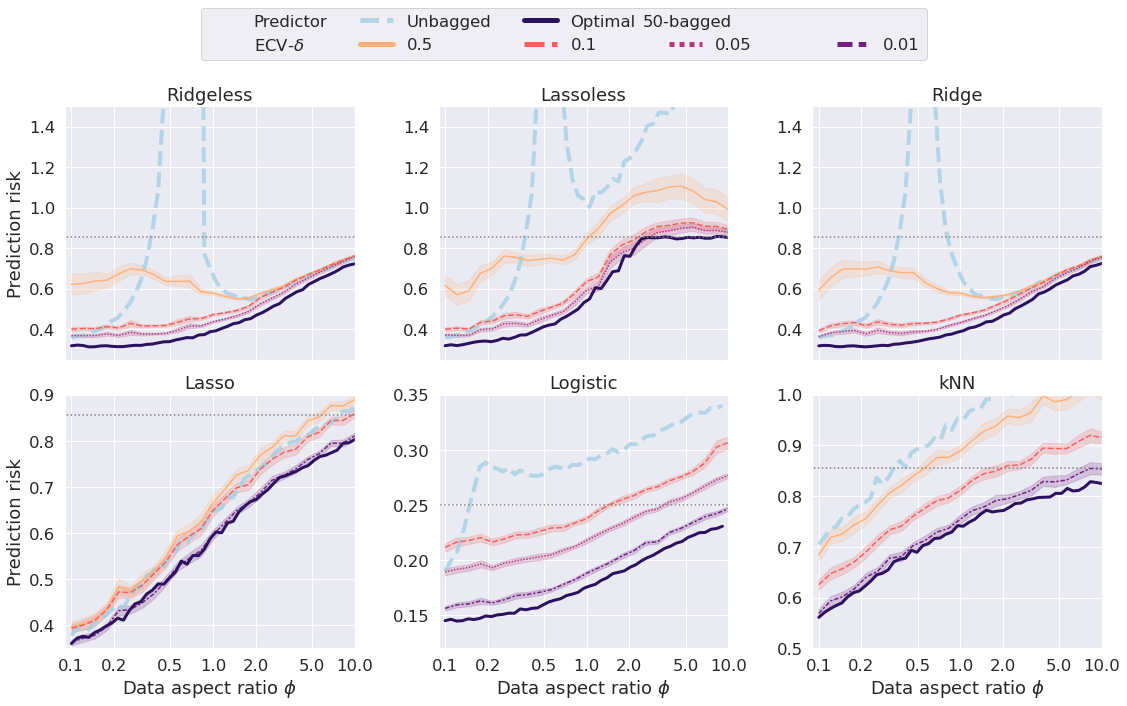

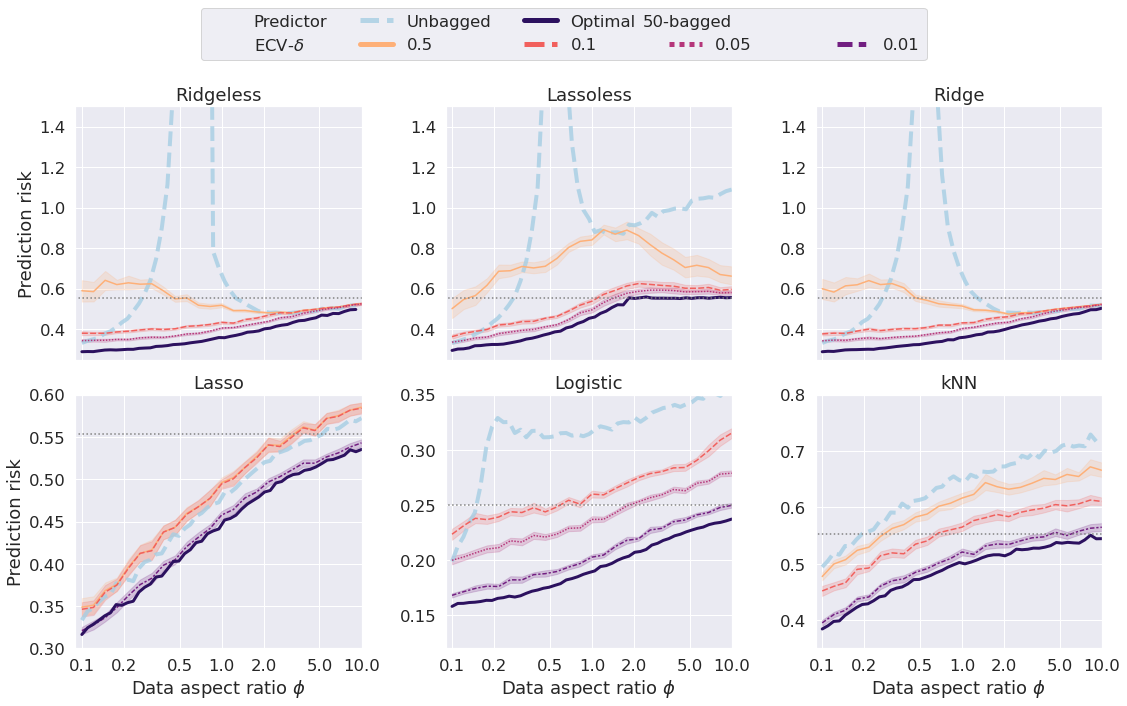

In [4]:
delta_dict = {
    'ridgeless':np.array([5e-2, 1e-1, 5e-1]),
    'ridge':np.array([5e-2, 1e-1, 5e-1]),
    'lassoless':np.array([5e-2, 1e-1, 5e-1]),
    'lasso':np.array([1e-2, 1e-1, 5e-1]),
    'logistic':np.array([1e-2, 5e-2, 1e-1]),
    'kNN':np.array([1e-2, 1e-1, 5e-1]),
}

delta_list_all = -np.sort(-np.array([1e-2, 5e-2, 1e-1, 5e-1]))
cm = sns.color_palette("magma_r", len(delta_list_all)+1)

func_list = ['linear', 'quad', 'tanh']
bagging_list = ['bagging', 'subagging']
bagging = 'bagging'
predictor_list = ['ridgeless', 'lassoless', 'ridge', 'lasso', 'logistic', 'kNN']
rho_ar1 = 0.5
n = 1000
M_max = 50
for func in func_list:
    df_res = pd.DataFrame()
    df_res_the = pd.DataFrame()
    df_res_the_cv = pd.DataFrame()

    null_risk_list = []
    for predictor in predictor_list:
        delta_list = delta_dict[predictor]
        delta_str = np.char.add('delta-', delta_list.astype(str))

        file_name = 'result/ex2/res_cv_{}_{}_{}.pkl'.format(func, bagging, predictor)
        _df = pd.read_pickle(file_name, compression='gzip')
        _df = _df[_df['ar1rho']==rho_ar1]

        null_risk_val = _df.loc[_df['k_list']==0,_df.columns.str.startswith('val-')].values.mean()
        _df.loc[np.any(_df[['val-1','val-2']] > np.minimum(5*null_risk_val, 1e5), axis=1), ['val-1','val-2']] = np.nan
        _df['diff_2R2_R1'] = 2 * _df['val-2'] - _df['val-1']
        null_risk = _df.loc[_df['k_list']==0,_df.columns.str.startswith('test-')].values.mean()
        null_risk_list.append(null_risk)

        _df = _df.loc[_df.groupby(['phi','seed'])['diff_2R2_R1'].idxmin()].reset_index(drop=True)
        _df['diff_R1_R2'] = _df['val-1'] - _df['val-2']

        _df['RM'] = _df['diff_2R2_R1'] + 2/M_max*_df['diff_R1_R2']
        _df['diff_RM_Rinf'] = _df['RM'] - _df['diff_2R2_R1']

        _df = _df.loc[_df.groupby(['phi','seed'])['RM'].idxmin()].reset_index(drop=True)
        _df[np.char.add('M_hat-',delta_str)] = np.ceil(
            _df['diff_R1_R2'].values[:,None] * 2 / (delta_list[None,:] + _df['diff_RM_Rinf'].values[:,None])
        ).astype(int)

        _df[np.char.add('risk-',delta_str)] = np.take_along_axis(
            _df.loc[:,_df.columns.str.startswith('test-')].values,
            _df[np.char.add('M_hat-',delta_str)].values - 1, axis=-1
        )
        _df['phi_s'] = _df['phi']*n/_df['k_list']

        _df = _df[np.r_[[
            'phi', 'phi_s', 'seed'], np.char.add('M_hat-',delta_str), np.char.add('risk-',delta_str)]
             ]
        _df = pd.wide_to_long(
            _df, stubnames=[r'M_hat', r'risk'], 
            i=['phi', 'phi_s', 'seed'], j='delta', sep='-delta-', suffix='.*'
        ).reset_index()
        _df['Predictor'] = predictor
        df_res = pd.concat([df_res, _df], axis=0)

        
        file_name = 'result/ex2/res_risk_{}_{}_{}.pkl'.format(func, bagging, predictor)
        _df = pd.read_pickle(file_name, compression='gzip')
        _df = _df[_df['ar1rho']==rho_ar1]
        _df.columns = ['phi','phi_s']+np.char.add('risk-',np.arange(1,51).astype(str)).tolist() + ['ar1rho']
        _df = _df.drop_duplicates(['phi','phi_s'])
        _df = pd.wide_to_long(_df, stubnames='risk', i=['phi', 'phi_s'], j='M', sep='-').reset_index()
        _df['M'] = _df['M'].astype(int).astype(str)
        _df['Predictor'] = predictor
        df_res_the_cv = pd.concat([
            df_res_the_cv, _df.loc[_df.groupby(['Predictor','phi','M'])['risk'].idxmin()]], axis=0)
        _df = _df[_df['M']=='1']
        df_res_the = pd.concat([
            df_res_the, _df.loc[_df.groupby(['Predictor','phi'])['phi_s'].idxmin()]], axis=0)


    sns.set(font_scale=1.5)
    fig, axes = plt.subplots(
        2,3,figsize=(16,10), sharex=True, sharey=False)
    ylim_dict = {
        'lassoless':[0.25, 1.5],
        'lasso':[0.35, 0.9] if func!='tanh' else [0.3,0.6],
        'ridgeless':[0.25, 1.5],
        'ridge':[0.25, 1.5],    
        'logistic':[0.12, 0.35],    
        'kNN':[0.5, 1.] if func!='tanh' else [0.35,0.8],
    }
    for i,j in itertools.product(np.arange(2), np.arange(3)):
        predictor = predictor_list[i*3+j]
        delta_list = delta_dict[predictor]
        delta_str = np.char.add('delta-', delta_list.astype(str))
        null_risk = null_risk_list[i*3+j]

        sns.lineplot(data=df_res_the[df_res_the['Predictor']==predictor], x='phi', y='risk', 
                     linestyle='--', ci=None, legend='full', linewidth=4,
                     color=sns.color_palette("Paired")[0], 
                     alpha=0.8, ax=axes[i,j], label='Unbagged')

        sns.lineplot(data=df_res[df_res['Predictor']==predictor], x='phi', y='risk', 
                     hue='delta', hue_order=delta_list[::-1], style='delta', style_order=delta_list_all,
                     palette=[cm[j] for j in np.where(np.in1d(delta_list_all, delta_dict[predictor]))[0]],
                     ax=axes[i,j],
                    )
        sns.lineplot(data=df_res_the_cv[
            (df_res_the_cv['Predictor']==predictor)&(df_res_the_cv['M']=='50')], x='phi', y='risk', 
                     linestyle='-', ci=None, linewidth=3,
                     color=cm[-1], ax=axes[i,j], label='Optimal 50-bagged')

        axes[i,j].set_title('{}'.format(
            np.char.capitalize(predictor) if predictor!='kNN' else 'kNN'
        ))
        axes[i,j].set_xlabel('Data aspect ratio $\phi$')
        axes[i,j].legend(loc='lower right', title='$M$')
        axes[i,j].hlines(null_risk, 0., 10., linestyles='dotted', color='gray')

        axes[i,j].set_ylim(ylim_dict[predictor])

    axes[i,0].set_xscale('log', base=10)
    axes[i,0].set_xlim([0.09, 10.])
    ticks = [0.1,0.2,0.5,1.,2.,5.,10.,]
    axes[i,0].set_xticks(ticks, [ f"{x:.01f}" for x in ticks ])

    lines_labels = [ax.get_legend_handles_labels() for ax in axes.flatten()]
    handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    _, indices = np.unique(labels, return_index=True)
    indices = indices[::-1]
    h = handles[-3]
    handles = np.array(handles)[indices].tolist()
    handles[-1] = h
    labels = np.array(labels)[indices].tolist()

    for i,j in itertools.product(np.arange(2), np.arange(3)):
        if j!=0:
            axes[i,j].set_ylabel('')
        else:
            axes[i,j].set_ylabel('Prediction risk')
        axes[i,j].get_legend().remove()

    handles = [matplotlib.lines.Line2D([], [], color="none") for _ in range(2)] + \
        [handles[0], handles[2], handles[1], handles[3], 
         matplotlib.lines.Line2D([], [], color="none"), handles[4],
         matplotlib.lines.Line2D([], [], color="none"), handles[5],
        ]
    labels = ['Predictor', 'ECV-$\delta$', labels[0], labels[2],
             'Optimal', labels[3], '50', labels[4], '', labels[5], #'', labels[6]
             ]
    legend = fig.legend(handles=handles, labels=labels,
                        loc=9, ncol=5, title='')
    legend_title_left(legend)

    for item, label in zip(legend.legendHandles, legend.texts):
        if label._text  in ['50']:
            width=item.get_window_extent(fig.canvas.get_renderer()).width
            label.set_ha('left')
            label.set_position((-2.2*width,0))
            label.set_text('50-bagged')
        item.set_linewidth(5)

    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.savefig('result/fig_cv_{}_{}_{}.pdf'.format(func,rho_ar1,bagging), bbox_inches='tight', pad_inches=0, dpi=300)                

# Ex3 Risk CV classification

In [5]:
func = 'quad'
bagging = 'bagging'
predictor = 'logistic'

file_name = 'result/ex3/res_classification_{}_{}.pkl'.format(func,bagging)
df_res = pd.read_pickle(file_name, compression='gzip')


df_res['method'] = 'ECV'
for K in [3,5,10]:
    df_res.loc[df_res['K']==K,'method'] = 'KfoldCV ($K={}$)'.format(K)

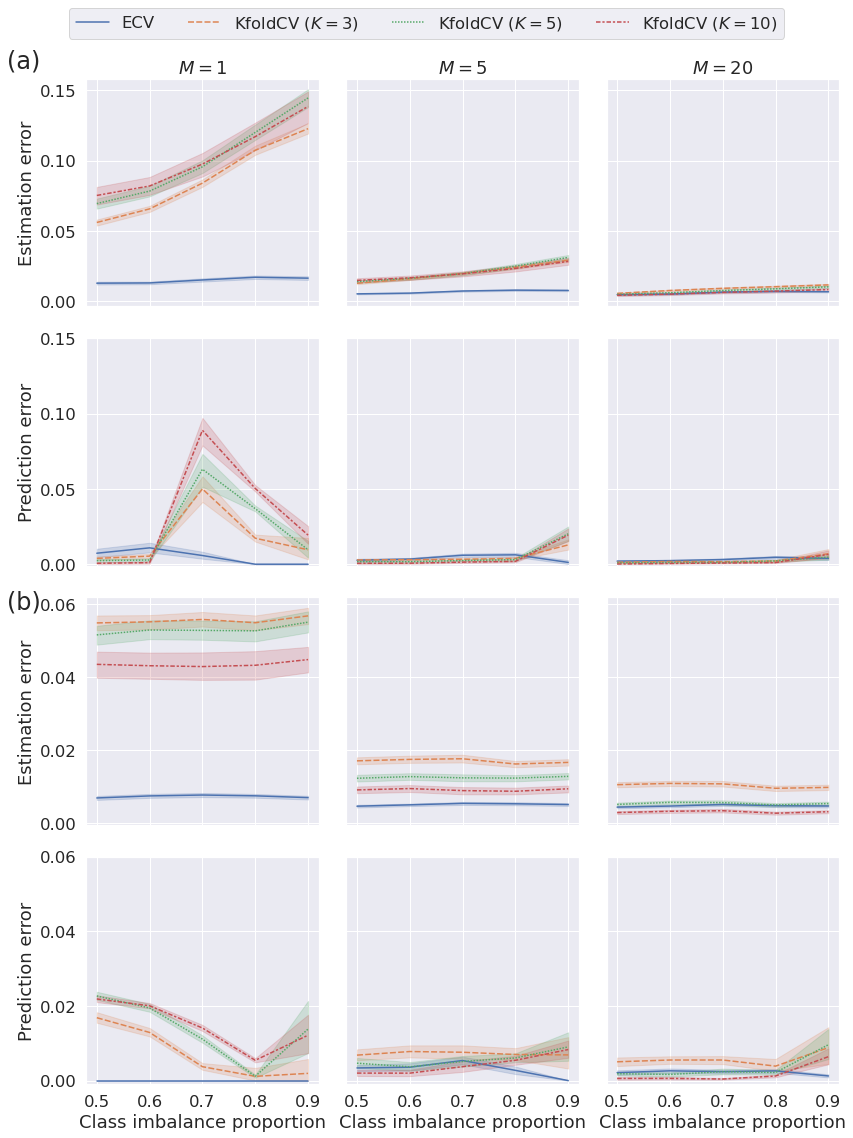

In [6]:
# 3-by-2
sns.set(font_scale=1.5)
fig, axes= plt.subplots(4,3,figsize=(12,16), sharey='row', sharex=True)
phi_list = [0.1,10]
M_list = [1,5,20]
for i,phi in enumerate(phi_list):
    if i==1:
        i += 1
    for j,M in enumerate(M_list):
        idx = (df_res['phi']==phi) & df_res['k_list'].isin(df_res[df_res['method']=='KfoldCV ($K=3$)']['k_list'].unique())
        df = df_res[idx]
        df['abs_err'] = np.abs(df['test-{}'.format(M)]-df['val-{}'.format(M)])
        sns.lineplot(df, x='prop', y='abs_err', hue='method', style='method',
                     hue_order=df_res['method'].unique(), style_order=df_res['method'].unique(),
                     ax=axes[i,j])
        
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

for i,j in itertools.product(np.arange(2), np.arange(3)):
    if i==1:
        i += 1
    if j!=0:
        axes[i,j].set_ylabel('')
    else:
        axes[i,j].set_ylabel('Estimation error')
    if i==0:
        axes[i,j].set_title('$M={}$'.format(M_list[j]))
    else:
        axes[i,j].set_xlabel('Class imbalance proportion')
        axes[i,1].set_xticks(np.arange(5,10)/10)
    axes[i,j].get_legend().remove()

legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=5, title='')
legend_title_left(legend)


phi_list = [0.1,10]
M_list = [1,5,20]
for i,phi in enumerate(phi_list):
    if i==1:
        i += 1
    for j,M in enumerate(M_list):
        idx = (df_res['phi']==phi) & df_res['k_list'].isin(df_res[df_res['method']=='KfoldCV ($K=3$)']['k_list'].unique())
        df = df_res[idx].reset_index(drop=True)
        col_val = np.char.add('val-',np.arange(1,M+1).astype(str)).tolist()
        col_risk = np.char.add('risk-',np.arange(1,M+1).astype(str)).tolist()
        col_test = np.char.add('test-',np.arange(1,M+1).astype(str)).tolist()
        df['cv_risk_val'] = df[col_val].values[np.arange(df.shape[0]), np.argmin(df[col_val], axis=1)]
        df['cv_risk'] = df[col_test].values[np.arange(df.shape[0]), np.argmin(df[col_val], axis=1)]        
        df['opt_risk'] = df[col_test].values[np.arange(df.shape[0]), np.argmin(df[col_test], axis=1)]
        opt_risk = df.groupby(['method','phi','seed','prop'])['opt_risk'].min().values
        df = df.loc[df.groupby(['method','phi','seed','prop'])['cv_risk_val'].idxmin()].reset_index(drop=True)
        df['opt_risk'] = opt_risk        
        df['abs_err'] = df['cv_risk'] - df['opt_risk']

        sns.lineplot(df, x='prop', y='abs_err', hue='method', style='method', 
                     hue_order=df_res['method'].unique(), style_order=df_res['method'].unique(),
                     ax=axes[i+1,j])
        
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

for i,j in itertools.product(np.arange(2), np.arange(3)):
    if i==1:
        i += 1
    if j!=0:
        axes[i+1,j].set_ylabel('')
    else:
        axes[i+1,j].set_ylabel('Prediction error')
    if i==0:
        pass
    else:
        axes[i+1,j].set_xlabel('Class imbalance proportion')
        axes[i+1,1].set_xticks(np.arange(5,10)/10)
    axes[i+1,j].get_legend().remove()
    
    if i==0:
        axes[i+1,j].set_ylim([-0.001,0.15])
    else:
        axes[i+1,j].set_ylim([-0.001,0.06])

plt.figtext(0.01, 0.94, '(a)', fontsize=24)
plt.figtext(0.01, 0.47, '(b)', fontsize=24)


fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.savefig('result/fig_clf.pdf', bbox_inches='tight', pad_inches=0, dpi=300)    

# Ex4 Random forest

## The impact of $\rho_{ar1}$

In [7]:
file_name = 'result/ex4/res_rho.pkl'
df_res = pd.read_pickle(file_name, compression='gzip')

M_max = 500
M_list = np.append(np.arange(1,M_max+1), np.inf)
M_str = ['risk-{:d}'.format(int(M)) for M in M_list[:-1]] + ['risk-$\infty$']
df_res.columns = np.append(np.append(['phi', 'seed', 'type', 'rho2', 'sigma2'], M_str), ['rho_ar1'])

df_val = df_res[df_res['type']=='oobcv_emp'].set_index(['phi', 'rho_ar1'])
df_test = df_res[df_res['type']=='risk_emp'].set_index(['phi', 'rho_ar1'])
df_null = df_res[df_res['type']=='null_risk'].set_index(['phi', 'rho_ar1'])



def comp_stat(df_val, df_test, keys, _type):
    _df = (df_val[keys] - df_test[keys]).abs() / df_null[keys]
    index_names = list(_df.index.names)
    mean = pd.DataFrame(_df.reset_index().groupby(index_names).mean().mean(axis=1), columns=['value'])
    mean['stat'] = 'mean'
    _df = ((df_val[keys] - df_test[keys]).abs() / df_null[keys]
           - np.repeat(mean['value'], df_null.shape[0]//mean.shape[0]).values[:,None])**2
    std = pd.DataFrame(_df.reset_index().groupby(index_names).mean().mean(axis=1) ** (1/2), columns=['value'])
    std['stat'] = 'sd'
    _df = pd.concat([mean, std], axis=0)
    _df['type'] = _type
    return _df


def summary(df_val, df_test):
    df_summary = pd.DataFrame()
    # estimation error
    _df = comp_stat(df_val, df_test, M_str[:-1], 'estimation error')
    df_summary = pd.concat([df_summary,_df], axis=0)

    # prediction error
    col_risk = np.char.add('risk-',np.arange(1,M+1).astype(str)).tolist()
    df_val['cv_risk'] = df_test[col_risk].values[np.arange(df_test.shape[0]), np.argmin(df_val[col_risk], axis=1)]
    df_test['cv_risk'] = df_test[col_risk].values[np.arange(df_test.shape[0]), np.argmin(df_test[col_risk], axis=1)]
    df_null['cv_risk'] = df_null[M_str[:1]]
    _df = comp_stat(df_val, df_test, ['cv_risk'], 'prediction error')
    df_summary = pd.concat([df_summary,_df], axis=0)
    return df_summary



df_summary = summary(df_val, df_test)
df_summary = df_summary.reset_index().pivot(index=['type','phi','stat'], columns='rho_ar1', values='value')
df_summary

rho_ar1                        -0.75     -0.50     -0.25      0.00      0.25  \
type             phi  stat                                                     
estimation error 0.1  mean  0.066295  0.082195  0.111935  0.115768  0.105336   
                      sd    0.047115  0.080345  0.080347  0.094832  0.081907   
                 10.0 mean  0.132164  0.134809  0.152368  0.127733  0.134758   
                      sd    0.108010  0.092706  0.114451  0.110191  0.114502   
prediction error 0.1  mean  0.000402  0.000246  0.000733  0.000580  0.000341   
                      sd    0.000764  0.000732  0.001790  0.001431  0.000925   
                 10.0 mean  0.000420  0.000444  0.001026  0.000377  0.000517   
                      sd    0.000882  0.000949  0.002169  0.001120  0.001335   

rho_ar1                         0.50      0.75  
type             phi  stat                      
estimation error 0.1  mean  0.091562  0.055167  
                      sd    0.081625  0.071428  
                 10.0 mean  0.114276  0.115397  
                      sd    0.110671  0.100362  
prediction error 0.1  mean  0.000337  0.000437  
                      sd    0.000822  0.000732  
                 10.0 mean  0.000732  0.000443  
                      sd    0.001556  0.000832

## The impact of $M_0$

In [8]:
file_name = 'result/ex4/res_M0.pkl'
df_res = pd.read_pickle(file_name, compression='gzip')

M_max = 500
M_list = np.append(np.arange(1,M_max+1), np.inf)
M_str = ['risk-{:d}'.format(int(M)) for M in M_list[:-1]] + ['risk-$\infty$']
df_res.columns = np.append(np.append(['phi', 'seed', 'type', 'rho2', 'sigma2'], M_str), ['time','M0'])

df_val = df_res[df_res['type']=='oobcv_emp'].set_index(['phi', 'M0'])
df_test = df_res[df_res['type']!='oobcv_emp'].set_index(['phi', 'M0'])

df_null = df_null.reset_index()
df_null = df_null[df_null['rho_ar1']==0.5]
df_null = df_null.iloc[np.tile(np.arange(len(df_null)), 5)].reset_index(drop=True)
df_null['M0'] = df_res[df_res['type']!='oobcv_emp']['M0'].values
df_null = df_null.set_index(['phi', 'M0'])

df_summary = summary(df_val, df_test)

# time
index_names = list(df_val.index.names)
mean = pd.DataFrame(df_val.reset_index().groupby(['phi', 'M0'])['time'].mean())
mean.columns = ['value']
mean['stat'] = 'mean'
std = pd.DataFrame(df_val.reset_index().groupby(['phi', 'M0'])['time'].std())
std.columns = ['value']
std['stat'] = 'sd'
_df = pd.concat([mean, std], axis=0)
_df['type'] = 'time'
df_summary = pd.concat([df_summary,_df],axis=0)


df_summary = df_summary.reset_index().pivot(index=['type','phi','stat'], columns='M0', values='value')
df_summary

M0                                5         10        15        20        25
type             phi  stat                                                  
estimation error 0.1  mean  0.087431  0.073141  0.066819  0.063836  0.066082
                      sd    0.069105  0.057045  0.062766  0.088081  0.069598
                 10.0 mean  0.113275  0.131053  0.115559  0.105756  0.094538
                      sd    0.108963  0.127159  0.088164  0.093888  0.081225
prediction error 0.1  mean  0.000179  0.000614  0.000354  0.000366  0.000137
                      sd    0.000558  0.001183  0.001094  0.001090  0.000431
                 10.0 mean  0.000233  0.000305  0.000222  0.000226  0.000177
                      sd    0.000614  0.001075  0.000717  0.000681  0.000537
time             0.1  mean  0.071849  0.087003  0.106737  0.138752  0.172753
                      sd    0.029462  0.034590  0.029229  0.038117  0.030129
                 10.0 mean  0.924912  1.254317  1.449232  1.911151  1.965244
                      sd    0.270237  0.336010  0.374633  0.438279  0.403543

## The impact of covariance structure

In [9]:
file_name = 'result/ex4/res_cov.pkl'
df_res = pd.read_pickle(file_name, compression='gzip')

M_max = 500
M_list = np.append(np.arange(1,M_max+1), np.inf)
M_str = ['risk-{:d}'.format(int(M)) for M in M_list[:-1]] + ['risk-$\infty$']
df_res.columns = np.append(np.append(['phi', 'seed', 'type', 'rho2', 'sigma2'], M_str), ['n_block'])

df_val = df_res[df_res['type']=='oobcv_emp'].set_index(['phi', 'n_block'])
df_test = df_res[df_res['type']=='risk_emp'].set_index(['phi', 'n_block'])
df_null = df_res[df_res['type']=='null_risk'].set_index(['phi', 'n_block'])

In [10]:
df_summary = summary(df_val, df_test)
df_summary = df_summary.reset_index().pivot(index=['type','phi','stat'], columns='n_block', values='value')
df_summary

n_block                            1         2         3
type             phi  stat                              
estimation error 0.1  mean  0.115768  0.082695  0.072476
                      sd    0.072944  0.051295  0.073637
                 10.0 mean  0.127733  0.128749  0.149737
                      sd    0.118958  0.098788  0.100330
prediction error 0.1  mean  0.000580  0.000401  0.000385
                      sd    0.001424  0.000894  0.000917
                 10.0 mean  0.000377  0.000461  0.000396
                      sd    0.001119  0.001012  0.001091

## Extrapolate path

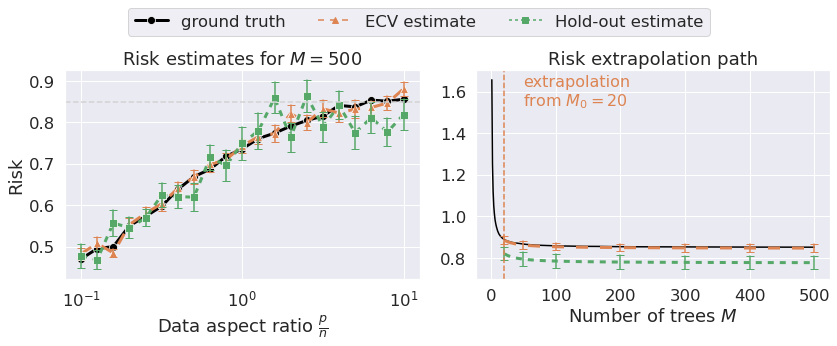

In [11]:
func = 'quad'
bagging = 'bagging'
predictor = 'tree'
rho_ar1 = 0.5

file_name = 'result/ex4/res_path.pkl'
_df = pd.read_pickle(file_name, compression='gzip')
null_risk = (_df['rho2'] + _df['sigma2']).mean()
_df.columns = ['phi','seed', 'type', 'rho2', 'sigma2']+np.char.add('risk-',np.arange(1,501).astype(str)).tolist() + [r'risk-0']
_df = pd.wide_to_long(_df, stubnames='risk', i=['phi', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
_df.loc[_df['M']==0,'M'] = np.inf

_df = _df.sort_values(['phi','seed','M'])

sns.set(font_scale=1.5)

hue_order = ['risk_emp', 'oobcv_emp', 'hold_emp']
cm = sns.color_palette()

fig, axes = plt.subplots(1,2,figsize=(12,5))
ids = (_df['phi']<11.)
sns.lineplot(data=_df[ids&(_df['type']=='risk_emp')&(_df['M']==500)], 
             x='phi', y='risk', lw=3, markersize=8,
             marker='o', color='black', ci=None, 
             label='ground truth', ax=axes[0])
sns.lineplot(data=_df[ids&(_df['type']!='risk_emp')&(_df['M']==500)], 
             x='phi', y='risk', lw=3, markersize=8, 
             style='type', style_order=hue_order[1:3], 
             dashes=[(4,4),(2,2)], markers=['^', 's'], 
             errorbar=("se", 1), err_style='bars', err_kws={'capsize':4,'capthick':1},
             hue='type', hue_order=hue_order[1:3], palette=cm[1:3], ax=axes[0])

axes[0].set_xlabel('Data aspect ratio $\\frac{p}{n}$')
axes[0].set_title('Risk estimates for $M=500$')
axes[0].set_ylabel('Risk')

axes[0].axhline(null_risk, linestyle='--', color='lightgray')

ids = (_df['phi']>7)&(_df['phi']<10)
sns.lineplot(
    data=_df[ids&(_df['type']=='risk_emp')], 
    x='M', y='risk', color='black', ci=None, label='ground truth', ax=axes[1])
sns.lineplot(data=_df[ids&(_df['type']!='risk_emp')&(_df['M']>20)],             
             x='M', y='risk', lw=3,
             style='type', style_order=hue_order[1:3], 
             dashes=[(4,4),(2,2)], ci=None,
             hue='type', hue_order=hue_order[1:3], palette=cm[1:3], ax=axes[1])
sns.lineplot(data=_df[ids&(_df['type']!='risk_emp')&(_df['M'].isin([20,50, 100, 200,300,400, 500]))],             
             x='M', y='risk', lw=3, markersize=8,  linestyle='',
             style='type', style_order=hue_order[1:3], 
             dashes=[(0,4),(0,2)], legend=False,
             errorbar=("se", 1), err_style='bars', err_kws={'capsize':4,'capthick':1},
             hue='type', hue_order=hue_order[1:3], palette=cm[1:3], ax=axes[1])
axes[1].set_xlabel('Number of trees $M$')
axes[1].set_title('Risk extrapolation path')
axes[1].set_ylabel('')
axes[0].set_xscale('log')

ylim = axes[1].get_ylim()
axes[1].vlines(20, ylim[0], ylim[1], linestyle='--', color=cm[1])
axes[1].set_ylim(ylim)
axes[1].text(50, ylim[1]*0.9, 'extrapolation\nfrom $M_0=20$', 
             color=cm[1], fontsize=16)


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

for j in range(2):
    axes[j].get_legend().remove()

legend = fig.legend(handles=handles, 
                    labels=['ground truth', 'ECV estimate', 'Hold-out estimate'], loc=9, ncol=9)

fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.savefig('result/fig_ar1_rf_{}.pdf'.format(bagging), bbox_inches='tight', pad_inches=0, dpi=300)

## Tuning number of features

In [12]:
func = 'quad'
bagging = 'bagging'
predictor = 'tree'
path_result = 'result/ex4/{}/{}/'.format(bagging,predictor)

rho_ar1 = 0.5
sigma = 5

n = 100
phi = 10
p = int(n*phi)
df_res = pd.DataFrame()
for i in range(50):
    file_saved = path_result+'res_mtry_rho_{:0.02f}_sigma_{:0.01f}_seed_{}.csv'.format(rho_ar1,sigma,i)
    _df = pd.read_csv(file_saved)
    df_res = pd.concat([df_res, _df], axis=0)

df_res['phi_s'] = p/df_res['k_list'].values
df_res = df_res.reset_index(drop=True)

df_M = pd.DataFrame()
for M in range(10,101,10):
    df = df_res.copy()
    col_val = np.char.add('val-',np.arange(1,M+1).astype(str)).tolist()
    col_test = np.char.add('test-',np.arange(1,M+1).astype(str)).tolist()
    df['cv_risk_val'] = df[col_val].values[np.arange(df.shape[0]), np.argmin(df[col_val], axis=1)]
    df['cv_risk'] = df[col_test].values[np.arange(df.shape[0]), np.argmin(df[col_val], axis=1)]        
    df['opt_risk'] = df[col_test].values[np.arange(df.shape[0]), np.argmin(df[col_test], axis=1)]
    opt_risk = df.groupby(['seed'])['opt_risk'].min().values
    untuned_risk = df.loc[df.groupby(['seed'])['k_list'].idxmax()]['test-{}'.format(M)].values
    null_risk = df[df['k_list']==0][col_test].mean(axis=1).values
    df = df.loc[df.groupby(['seed'])['cv_risk_val'].idxmin()].reset_index(drop=True)

    df['opt_risk'] = opt_risk
    abs_err = (untuned_risk - df['cv_risk'])/null_risk * 100
    _df = pd.DataFrame({'abs_err':abs_err, 'M':np.full(len(abs_err), M)})
    df_M = pd.concat([df_M,_df])

df_res = pd.DataFrame()
for i in range(50):
    file_saved = path_result+'res_max_features_rho_{:.02f}_sigma_{:.01f}_seed_{}.csv'.format(rho_ar1,sigma,i)
    _df = pd.read_csv(file_saved)
    df_res = pd.concat([df_res, _df], axis=0)

df_res = df_res.reset_index(drop=True)

df_time = df_res[df_res['type']!='risk_emp']
df_time['$M_0$'] = np.where(df_time['type']=='oobcv_emp', 20, 100)

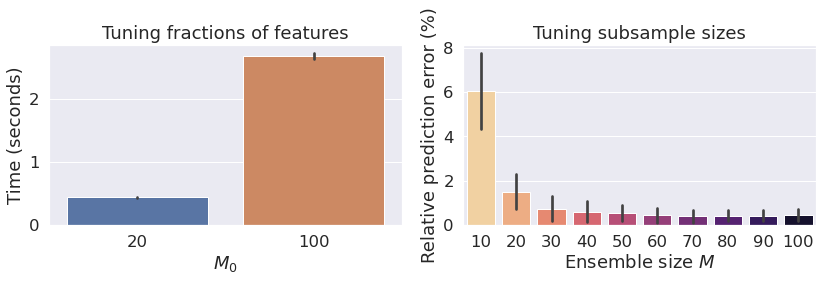

In [13]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(1,2,figsize=(12,4))

sns.barplot(df_time, y='time', x='$M_0$', ax=axes[0])
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Tuning fractions of features')

sns.barplot(data=df_M, y='abs_err', x='M', palette=sns.color_palette("magma_r", n_colors=10), ax=axes[1])
axes[1].set_xlabel('Ensemble size $M$')
axes[1].set_ylabel('Relative prediction error (%)')
axes[1].set_title('Tuning subsample sizes')

fig.tight_layout()
plt.savefig('result/fig_mtry.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Ex5 Real data

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

with h5py.File('pbmc_count.h5', 'r') as f:
    print(f.keys())
    ADT_names = np.array(f['ADT_names'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    X = sp.sparse.csc_matrix(
        (np.array(f['RNA.data'], dtype=np.float32), 
         np.array(f['RNA.indices'], dtype=np.int32),
         np.array(f['RNA.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['RNA.shape'], dtype=np.int32)).tocsc().astype(np.float32).T.toarray()
    Y = np.array(f['ADT'], dtype=np.float32)
    cell_types = np.array(f['celltype'], dtype='S32').astype(str)
    cell_ids = np.array(f['cell_ids'], dtype='S32').astype(str)
    
X = np.log(X/np.sum(X, axis=1, keepdims=True)*1e4+1.)
Y = np.log(Y/np.sum(Y, axis=1, keepdims=True)*1e4+1.)

cell_types_list = np.array(['DC', 'B', 'NK', 'Mono'])
method = 'tree'

<KeysViewHDF5 ['ADT', 'ADT_names', 'RNA.data', 'RNA.indices', 'RNA.indptr', 'RNA.shape', 'cell_ids', 'celltype', 'gene_names']>


## Figure 1 subagging

In [15]:
df_split = pd.read_csv('df_split.csv', index_col=[0])
df_split['celltype'] = cell_types
df_split = df_split[df_split['split']=='train']
df_split['count'] = 1
df_split = df_split.groupby(['celltype','split']).count().reset_index()

res_cv_all = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex5/{}/subagging/{}/'.format(celltype,method)

    res_cv = []
    cv_method_dict = {
        'splitcv':'splitCV', 
        'kfoldcv_3':'KfoldCV ($K=3$)',
        'kfoldcv_5':'KfoldCV ($K=5$)',
        'oobcv_50':'ECV',
        'oobcv_100':'ECV-100',
        'oobcv_250':'ECV',
    }

    for j,ADT_name in enumerate(ADT_names):
        for i in range(5):
            file_name = path_result + 'res_ADT_{}_test_{}.csv'.format(j, i)
            _df = pd.read_csv(file_name, index_col=0).sort_values('k_list')
            if i==0:
                df = _df
            else:
                df.loc[:,df.columns.str.startswith('test')] += _df.loc[:,df.columns.str.startswith('test')]
        df.loc[:,df.columns.str.startswith('test')] /= 5
        null_risk_test = df.loc[df['k_list']==0,df.columns.str.startswith('test')].mean().mean()
        res_test = df.loc[:,df.columns.str.startswith('test')].values
        res_test = res_test/null_risk_test
        res_test[:,50:] = np.inf
        k_hat = np.unique(df['k_list'].values)
        
        for cv_method in [
            'splitcv', 'kfoldcv_3', 'kfoldcv_5', 'oobcv_250',
        ]:
            file_name = path_result + 'res_ADT_{}_{}.csv'.format(j, cv_method.split('-')[0])
            df = pd.read_csv(file_name, index_col=0)
            df = df.sort_values('k_list')
            df = df[df['k_list'].isin(k_hat)]

            null_risk = df.loc[df['k_list']==0,df.columns.str.startswith('val')].mean().mean()
            res_val = df.loc[:,df.columns.str.startswith('val')].values
            res_val = res_val/null_risk
            res_val[:,50:] = np.inf
            for delta in [0.05]:
                idk, idM = np.where(res_val <= np.min(res_val) + delta)
    
                idMhat = np.min(idM)
                idkhat = np.argmin(res_val[:,idMhat])
                subopt = res_test[idkhat, idMhat] - np.min(res_test)

                res_cv.append([
                    ADT_name,
                    delta,
                    idMhat+1,
                    int(k_hat[idkhat]),
                    cv_method_dict[cv_method], 
                    subopt
                ])
    res_cv = pd.DataFrame(res_cv, columns=['ADT_name', 'delta', 'M', 'k', 'cv_method', 'subopt'])
    res_cv['celltype'] = celltype
    res_cv_all = pd.concat([res_cv_all, res_cv], axis=0)
    
res_cv_all = res_cv_all.sort_values(
    'celltype', key=lambda x:x.map({j:i for i,j in enumerate(cell_types_list)}))
res_cv_all['xlabels'] = res_cv_all['celltype'].map(
    {j:j+'\n$n$={:d}'.format(
        df_split.loc[df_split['celltype']==j,'count'].iloc[0]
    ) for i,j in enumerate(cell_types_list)})

cv_method_dict = {
    'splitcv':'splitCV', 
    'kfoldcv-3':'KfoldCV ($K=3$)',
    'kfoldcv-5':'KfoldCV ($K=5$)',
    'oobcv-50':'ECV-50',
    'oobcv-100':'ECV-100',
    'oobcv-250':'ECV-250',
}

df = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex5/{}/subagging/{}/'.format(celltype,method)

    res_cv = []
    _df = pd.read_csv(path_result+'res_time_{}.csv'.format(method), index_col=0)
    _df = pd.melt(_df, id_vars=['ADT_name'], value_vars=[
        'splitcv', 'oobcv-50','oobcv-100','oobcv-250','kfoldcv-3', 'kfoldcv-5',
    ], var_name='cv_method', value_name='time')
    _df['cv_method'] = _df['cv_method'].apply(lambda x:cv_method_dict[x])
    _df['celltype'] = celltype
    df = pd.concat([df, _df], axis=0)

df = df.sort_values(
    'celltype', key=lambda x:x.map({j:i for i,j in enumerate(cell_types_list)}))
df['xlabels'] = df['celltype'].map(
    {j:j+'\n$n$={:d}'.format(
        df_split.loc[df_split['celltype']==j,'count'].iloc[0]
    ) for i,j in enumerate(cell_types_list)})
df = df[df['cv_method'].isin(['splitCV','KfoldCV ($K=3$)','KfoldCV ($K=5$)','ECV-250'])]
df = df.reset_index(drop=True)
df.loc[df['cv_method'] == 'ECV-250', 'cv_method'] = 'ECV'

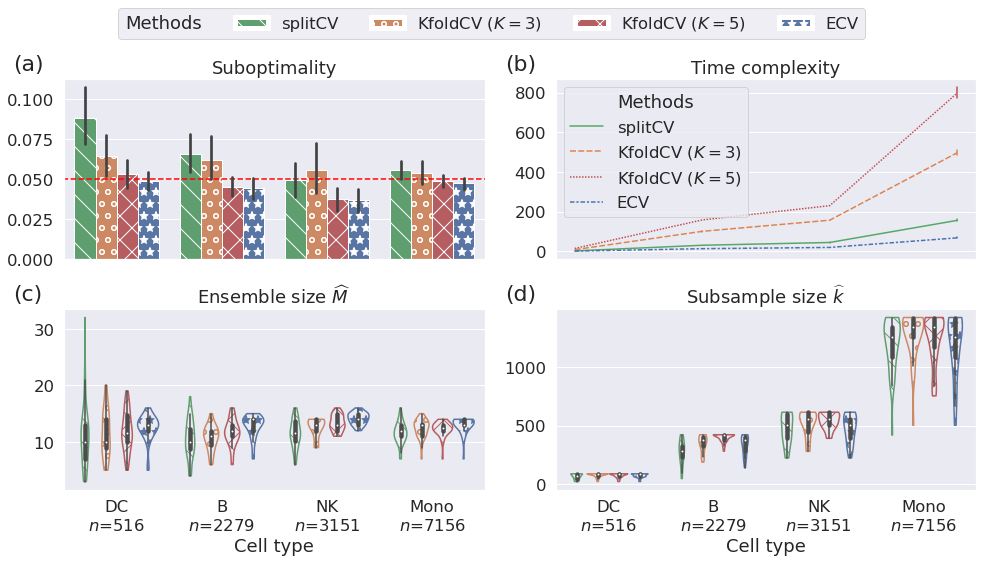

In [16]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(2,2,figsize=(14,8))
delta = 0.05
hue_order=['splitCV','KfoldCV ($K=3$)','KfoldCV ($K=5$)','ECV']
cmap = [sns.color_palette()[2], sns.color_palette()[1], sns.color_palette()[3], sns.color_palette()[0]]
bar = sns.barplot(
    data=res_cv_all[res_cv_all['delta']==delta], x='xlabels', y='subopt', 
    hue='cv_method', hue_order=hue_order,
    ax=axes[0,0], estimator='mean', palette = cmap
)

    
xlim = axes[0,0].get_xlim()
axes[0,0].hlines(delta, xlim[0]-1, xlim[1]+1, 
               linestyle='--', color='red', zorder=1)
axes[0,0].set_xlim(xlim)
axes[0,0].set_title('Suboptimality')

violin = sns.violinplot(
    data=res_cv_all[(res_cv_all['delta']==delta)&(res_cv_all['k']!=0)], x='xlabels', y='M', cut=0,
    hue='cv_method', hue_order=hue_order, style='cv_method', style_order=hue_order, 
    ax=axes[1,0], palette = cmap,
)
axes[1,0].set_title('Ensemble size $\widehat{M}$')

sns.violinplot(
    data=res_cv_all[(res_cv_all['delta']==delta)&(res_cv_all['k']!=0)], x='xlabels', y='k', cut=0,
    hue='cv_method', hue_order=hue_order, style='cv_method', style_order=hue_order, 
    ax=axes[1,1], palette = cmap
)
axes[1,1].set_title('Subsample size $\widehat{k}$')

# Add hatches
hatches = [ '\\', 'o', 'x', '*']
for i,thisbar in enumerate(bar.patches):
    thisbar.set_hatch(hatches[i//4])

for j in range(2):
    ihatch = iter(np.tile(hatches,4))
    for i in axes[i_row,j].get_children():
        if isinstance(i, matplotlib.collections.PolyCollection):
            i.set_edgecolor(i.get_facecolor())
            i.set_facecolor('none')
            i.set_hatch(next(ihatch))

            
sns.lineplot(
    data=df, x='xlabels', hue='cv_method', y='time',
    estimator='mean', err_style='bars', hue_order=hue_order, 
    style='cv_method', style_order=hue_order, 
    ax=axes[0,1], palette = cmap, sort= False)


for i in range(2):
    for j in range(2):
        if i==1:
            xlabel = 'Cell type'
        else:
            axes[i,j].set_xticks([])
            xlabel = ''
        axes[i,j].set_xlabel(xlabel)
        axes[i,j].set_ylabel('')
axes[0,1].set_title('Time complexity')

num = ['(a)', '(b)', '(c)', '(d)']
for i in range(2):
    for j in range(2):
        axes[i,j].text(-.12, 1.05, num[int(i*2+j)], 
                     size=22, transform=axes[i,j].transAxes)

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]

for i in range(2):
    for j in range(2):
        if i==0 and j==1:
            axes[0,1].get_legend().set_title('Methods')
            continue
        axes[i,j].get_legend().remove()

legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=5, title='Methods')
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    item.set_linewidth(5)
    label.set_ha('left')
    
plt.tight_layout()
fig.subplots_adjust(top=0.86)
plt.savefig('result/real_data_overview.pdf', bbox_inches='tight', pad_inches=0, dpi=300,)

## Figure 6

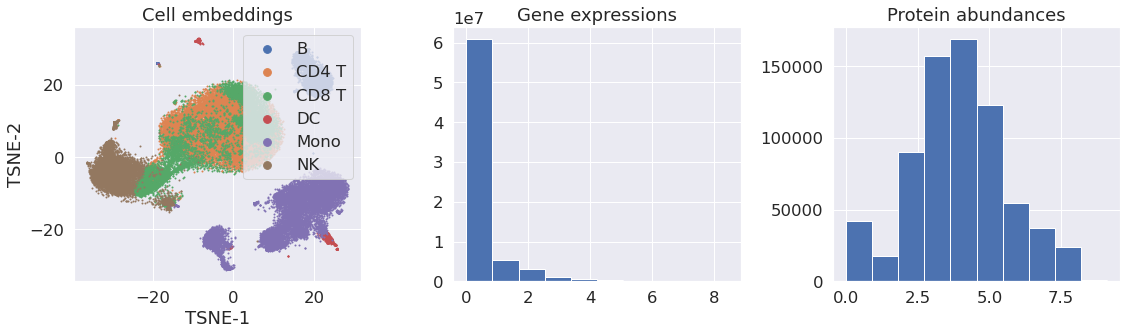

In [17]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1,3,figsize=(16,5))
for celltype in np.unique(cell_types):
    axes[0].scatter(
        *X_tsne[cell_types==celltype,:].T, s=1, label=celltype)
lgnd = axes[0].legend(loc="upper right")
for j in np.arange(len(np.unique(cell_types))):
    lgnd.legendHandles[j]._sizes = [60]
axes[0].set_xlabel('TSNE-1')
axes[0].set_ylabel('TSNE-2')
axes[0].set_title('Cell embeddings')

axes[1].hist(X[cell_types=='Mono',:].flatten())
axes[1].set_title('Gene expressions')

axes[2].hist(Y[cell_types=='Mono',:].flatten())
axes[2].set_title('Protein abundances')

plt.tight_layout()
plt.savefig(
    'result/fig_sc_overview.pdf', bbox_inches='tight', pad_inches=0, dpi=300,)

## Figure 7, Figure S5

In [18]:
cell_types_list = ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK']
method_list = ['ridge', 'lasso', ] 
celltype = cell_types_list[3]
method = 'tree'
cv_method = 'oobcv_250'
path_result = 'result/ex5/{}/subagging/{}/'.format(celltype,method)
j = 0
ADT_name = ADT_names[j]
df = pd.read_csv(path_result + 'res_ADT_{}_{}.csv'.format(
    j, cv_method.split('-')[0]), index_col=0)
df = df.sort_values('k_list')


k_hat = df['k_list'].values
res_val = df.loc[:,df.columns.str.startswith('val')].values
res_test = df.loc[:,df.columns.str.startswith('test')].values    

null_risk = np.mean(res_test[:1,:])
res_test /= null_risk
res_val /= null_risk
res_test = res_test[:,:50]
res_val = res_val[:,:50]

df_split = pd.read_csv('df_split.csv', index_col=[0])
n_cell = np.sum((df_split['split']=='train').values & (cell_types==celltype))
n_cell = n_cell*(1-1/np.log(n_cell))

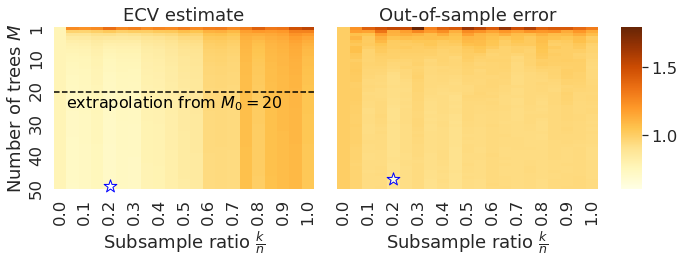

In [19]:

fig, axes = plt.subplots(
    1,3, figsize=(10,4), gridspec_kw={'width_ratios':[1,1,0.08]})
axes[0].get_shared_y_axes().join(axes[1])
sns.heatmap(
    pd.DataFrame(res_val, columns=np.arange(1,51).astype(int), 
                 index=np.round(k_hat/n_cell, 1)).T,
    yticklabels=[str(i) if i%10==0 or i==1 else '' for i in np.arange(1,51)],
    vmin=0.6, vmax=1.8,
    cmap=sns.color_palette("YlOrBr", as_cmap=True), cbar=False,
    ax=axes[0])
opt = np.unravel_index(np.argmin(res_val, axis=None), res_val.shape)
axes[0].scatter([opt[0]+0.5], [opt[1]],  marker='*', s=180, clip_on=False,
           edgecolors='blue', facecolor='white', linewidth=1, zorder=10)

sns.heatmap(
    pd.DataFrame(res_test, columns=np.arange(1,51).astype(int), 
                 index=np.round(k_hat/n_cell, 1)).T,
    vmin=0.6, vmax=1.8,
    cmap=sns.color_palette("YlOrBr", as_cmap=True), cbar_ax=axes[-1],
    ax=axes[1])
opt = np.unravel_index(np.argmin(res_test, axis=None), res_test.shape)
axes[1].scatter([opt[0]+0.5], [opt[1]],  marker='*', s=180, clip_on=False,
           edgecolors='blue', facecolor='lightyellow', linewidth=1, zorder=10)

axes[0].set_ylabel('Number of trees $M$')
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].set_yticklabels([])

for i in range(2):
    axes[i].set_xlabel('Subsample ratio $\\frac{k}{n}$')

axes[0].set_title('ECV estimate')
axes[1].set_title('Out-of-sample error')


for j in range(1):
    xlim = axes[j].get_xlim()
    axes[j].hlines(20, xlim[0], xlim[1], linestyle='--', color='black')
    axes[j].set_xlim(xlim)
    axes[j].text(xlim[0]+1, 25, 'extrapolation from $M_0=20$', color='black', fontsize=16)

plt.tight_layout()
plt.savefig('result/heatmap.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

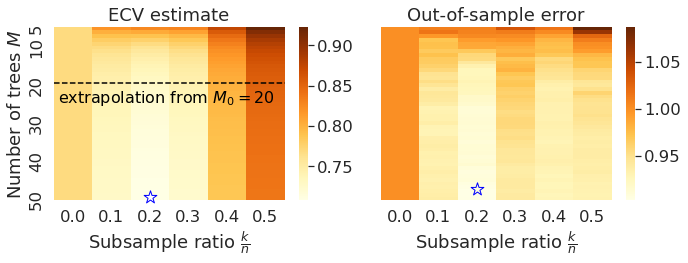

In [20]:
M0 = 5
Mmax = 50
ik = 12
idk = np.arange(0, ik, 2)
_res_val = res_val[idk,M0-1:Mmax]
_res_test = res_test[idk,M0-1:Mmax]
fig, axes = plt.subplots(
    1,2, figsize=(10,4), gridspec_kw={'width_ratios':[1,1]})
sns.heatmap(
    pd.DataFrame(_res_val, columns=np.arange(M0,Mmax+1).astype(int), 
                 index=np.round(k_hat[idk]/n_cell, 1)).T,
    yticklabels=[str(i) if i%10==0 or i==5 else '' for i in np.arange(M0,Mmax+1)],
    cmap=sns.color_palette("YlOrBr", as_cmap=True),
    ax=axes[0])
opt = np.unravel_index(np.argmin(_res_val, axis=None), _res_val.shape)
axes[0].scatter([opt[0]+0.5], [opt[1]],  marker='*', s=180, clip_on=False,
           edgecolors='blue', facecolor='white', linewidth=1, zorder=10)

sns.heatmap(
    pd.DataFrame(_res_test, columns=np.arange(M0,Mmax+1).astype(int), 
                 index=np.round(k_hat[idk]/n_cell, 1)).T,
    cmap=sns.color_palette("YlOrBr", as_cmap=True),
    ax=axes[1])
opt = np.unravel_index(np.argmin(_res_test, axis=None), _res_test.shape)
axes[1].scatter([opt[0]+0.5], [opt[1]],  marker='*', s=180, clip_on=False,
           edgecolors='blue', facecolor='lightyellow', linewidth=1, zorder=10)

axes[0].set_ylabel('Number of trees $M$')
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].set_yticklabels([])

for i in [0,1]:
    axes[i].set_xlabel('Subsample ratio $\\frac{k}{n}$')

axes[0].set_title('ECV estimate')
axes[1].set_title('Out-of-sample error')


for j in range(1):
    xlim = axes[j].get_xlim()
    axes[j].hlines(20-M0, xlim[0], xlim[1], linestyle='--', color='black')
    axes[j].set_xlim(xlim)
    axes[j].text(xlim[0]+0.1, 25-M0, 'extrapolation from $M_0=20$', color='black', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace = 0.1)
plt.savefig('result/heatmap_5.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

## Figure 8 subagging

In [21]:
res_cv_all = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex5/{}/subagging/{}/'.format(celltype,method)

    res_cv = []
    cv_method_dict = {
        'splitcv':'splitCV', 
        'kfoldcv_3':'3foldCV',
        'kfoldcv_5':'5foldCV',
        'oobcv_50':'ECV',
        'oobcv_100':'ECV-100',
        'oobcv_250':'ECV-250'
    }

    for j,ADT_name in enumerate(ADT_names):
        for i in range(5):
            file_name = path_result + 'res_ADT_{}_test_{}.csv'.format(j, i)
            _df = pd.read_csv(file_name, index_col=0).sort_values('k_list')
            if i==0:
                df = _df
            else:
                df.loc[:,df.columns.str.startswith('test')] += _df.loc[:,df.columns.str.startswith('test')]
        df.loc[:,df.columns.str.startswith('test')] /= 5
        null_risk_test = df.loc[df['k_list']==0,df.columns.str.startswith('test')].mean().mean()
        res_test = df.loc[:,df.columns.str.startswith('test')].values
        res_test = res_test/null_risk_test
        k_hat = np.unique(df['k_list'].values)
        
        for cv_method in [
            'splitcv', 'kfoldcv_3', 'kfoldcv_5', 'oobcv_50', 'oobcv_100', 'oobcv_250']:
            file_name = path_result + 'res_ADT_{}_{}.csv'.format(j, cv_method.split('-')[0])
            df = pd.read_csv(file_name, index_col=0)
            df = df.sort_values('k_list')
            df = df[df['k_list'].isin(k_hat)]

            for M_max in np.arange(1, 51):
                res_val = df.loc[:,df.columns.str.startswith('val')].values
                if cv_method in ['oobcv_100','oobcv_250']:
                    pass
                else:
                    res_val[:,M_max:] = np.inf

                res_cv.append([
                    ADT_name,
                    M_max,
                    cv_method_dict[cv_method], 
                    res_test[np.unravel_index(np.argmin(res_val, axis=None), res_val.shape)]
                ])
    res_cv = pd.DataFrame(res_cv, columns=['ADT_name', 'M_max', 'cv_method', 'NMSE'])
    res_cv['celltype'] = celltype
    res_cv_all = pd.concat([res_cv_all, res_cv], axis=0)

cv_method_dict = {
    'splitcv':'splitCV', 
    'kfoldcv-3':'3foldCV',
    'kfoldcv-5':'5foldCV',
    'oobcv-50':'ECV-50',
    'oobcv-100':'ECV-100',
    'oobcv-250':'ECV-250',
}

df = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex5/{}/subagging/{}/'.format(celltype,method)

    res_cv = []
    _df = pd.read_csv(path_result+'res_time_{}.csv'.format(method), index_col=0)
    _df = pd.melt(_df, id_vars=['ADT_name'], value_vars=[
        'splitcv', 'kfoldcv-3','kfoldcv-5', 'oobcv-50','oobcv-100','oobcv-250'
    ],
           var_name='cv_method', value_name='time')
    _df['cv_method'] = _df['cv_method'].apply(lambda x:cv_method_dict[x])
    _df['celltype'] = celltype
    df = pd.concat([df, _df], axis=0)

In [22]:
sns.set(font_scale=1.2)
fig, axes = plt.subplots(2,4,figsize=(15,8), sharex='row')
dim_dict = {
    'DC':r'($n\ll p$)', 'B':r'($n\approx p$)', 'NK':r'($n\approx p$)', 'Mono':r'($n\gg p$)'
}
hue_order=['splitCV', '3foldCV', '5foldCV', 'ECV']
for j in range(4):
    celltype = cell_types_list[j]
    i = 0
    sns.lineplot(
        data=res_cv_all[
            (res_cv_all['celltype']==celltype)&
            (~res_cv_all['cv_method'].isin(['ECV-100','ECV-250']))
        ], x='M_max', y='NMSE', estimator='mean', errorbar=None,
        hue='cv_method', hue_order=hue_order, style='cv_method', style_order=hue_order,
        palette = [sns.color_palette()[k] for k in [2,1,3,0]],
        ax=axes[i,j]
    )
    for iM,M in enumerate([100,250]):
        axes[i,j].scatter(
            51,
            res_cv_all[
                (res_cv_all['celltype']==celltype)&
                (res_cv_all['cv_method'].isin(['ECV-{}'.format(M)]))&
                (res_cv_all['M_max']==50)]['NMSE'].mean(), clip_on=False,
            marker='o', s=100, color=sns.color_palette()[4+iM], edgecolor='white', linewidth=1,
            label='ECV-{}'.format(M))
    ylim = axes[i,j].get_ylim()
    axes[i,j].vlines(20, ylim[0]-1, ylim[1]+1, color=sns.color_palette()[0], ls=':')
    axes[i,j].text(5, ylim[0]+(ylim[1]-ylim[0])*0.9, '$M_0=20$', color=sns.color_palette()[0])    
    axes[i,j].set_ylim(ylim)
    axes[i,j].legend()
    axes[i,j].set_title(celltype + ' ' + dim_dict[celltype])
    axes[i,j].set_xlim([1,51])
    axes[i,j].set_xlabel('$M_{\max}$')
    
    if j!=0:
        axes[i,j].set_ylabel('')
        
    i = 1
    sns.barplot(data=df[df['celltype']==celltype], palette = [sns.color_palette()[k] for k in [2,1,3,0,4,5]],
                x='cv_method', y='time', estimator='mean', ax=axes[i,j])
    
    if i==0:
        axes[i,j].set_xlabel('')
    else:
        axes[i,j].set_xlabel('Methods')
        axes[i,j].set_xticklabels(
            df['cv_method'].unique(), rotation=30,
        )
        
    if j==0:
        axes[i,j].set_ylabel('Time (seconds)')
    else:
        axes[i,j].set_ylabel('')
        
axes[0,0].text(-15., 1.02, '(a)', fontsize=20)
axes[1,0].text(-2.5, 15, '(b)', fontsize=20)
plt.tight_layout()
plt.savefig('result/real_data_{}.pdf'.format(method),
            bbox_inches='tight', pad_inches=0, dpi=300,)

## Figure 1 bagging

In [23]:
df_split = pd.read_csv('df_split.csv', index_col=[0])
df_split['celltype'] = cell_types
df_split = df_split[df_split['split']=='train']
df_split['count'] = 1
df_split = df_split.groupby(['celltype','split']).count().reset_index()

res_cv_all = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex5/{}/bagging/{}/'.format(celltype,method)

    res_cv = []
    cv_method_dict = {
        'splitcv':'splitCV', 
        'kfoldcv_3':'KfoldCV ($K=3$)',
        'kfoldcv_5':'KfoldCV ($K=5$)',
        'oobcv_50':'ECV',
        'oobcv_100':'ECV-100',
        'oobcv_250':'ECV',
    }

    for j,ADT_name in enumerate(ADT_names):
        for i in range(5):
            file_name = path_result + 'res_ADT_{}_test_{}.csv'.format(j, i)
            _df = pd.read_csv(file_name, index_col=0).sort_values('k_list')
            if i==0:
                df = _df
            else:
                df.loc[:,df.columns.str.startswith('test')] += _df.loc[:,df.columns.str.startswith('test')]
        df.loc[:,df.columns.str.startswith('test')] /= 5
        null_risk_test = df.loc[df['k_list']==0,df.columns.str.startswith('test')].mean().mean()
        res_test = df.loc[:,df.columns.str.startswith('test')].values
        res_test = res_test/null_risk_test
        res_test[:,50:] = np.inf
        k_hat = np.unique(df['k_list'].values)
        
        for cv_method in [
            'splitcv', 'kfoldcv_3', 'kfoldcv_5', 'oobcv_250',
        ]:
            file_name = path_result + 'res_ADT_{}_{}.csv'.format(j, cv_method.split('-')[0])
            df = pd.read_csv(file_name, index_col=0)
            df = df.sort_values('k_list')
            df = df[df['k_list'].isin(k_hat)]

            null_risk = df.loc[df['k_list']==0,df.columns.str.startswith('val')].mean().mean()
            res_val = df.loc[:,df.columns.str.startswith('val')].values
            res_val = res_val/null_risk
            res_val[:,50:] = np.inf
            for delta in [0.05]:
                idk, idM = np.where(res_val <= np.min(res_val) + delta)
    
                idMhat = np.min(idM)
                idkhat = np.argmin(res_val[:,idMhat])
                subopt = res_test[idkhat, idMhat] - np.min(res_test)

                res_cv.append([
                    ADT_name,
                    delta,
                    idMhat+1,
                    int(k_hat[idkhat]),
                    cv_method_dict[cv_method], 
                    subopt
                ])
    res_cv = pd.DataFrame(res_cv, columns=['ADT_name', 'delta', 'M', 'k', 'cv_method', 'subopt'])
    res_cv['celltype'] = celltype
    res_cv_all = pd.concat([res_cv_all, res_cv], axis=0)

res_cv_all = res_cv_all.sort_values(
    'celltype', key=lambda x:x.map({j:i for i,j in enumerate(cell_types_list)}))
res_cv_all['xlabels'] = res_cv_all['celltype'].map(
    {j:j+'\n$n$={:d}'.format(
        df_split.loc[df_split['celltype']==j,'count'].iloc[0]
    ) for i,j in enumerate(cell_types_list)})

cv_method_dict = {
    'splitcv':'splitCV', 
    'kfoldcv-3':'KfoldCV ($K=3$)',
    'kfoldcv-5':'KfoldCV ($K=5$)',
    'oobcv-50':'ECV-50',
    'oobcv-100':'ECV-100',
    'oobcv-250':'ECV-250',
}

df = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex5/{}/bagging/{}/'.format(celltype,method)

    res_cv = []

    _df = pd.read_csv(path_result+'res_time_{}.csv'.format(method), index_col=0)
    _df = pd.melt(_df, id_vars=['ADT_name'], value_vars=[
        'splitcv', 'oobcv-50','oobcv-100','oobcv-250','kfoldcv-3', 'kfoldcv-5',
    ],
           var_name='cv_method', value_name='time')
    _df['cv_method'] = _df['cv_method'].apply(lambda x:cv_method_dict[x])
    _df['celltype'] = celltype
    df = pd.concat([df, _df], axis=0)


df = df.sort_values(
    'celltype', key=lambda x:x.map({j:i for i,j in enumerate(cell_types_list)}))
df['xlabels'] = df['celltype'].map(
    {j:j+'\n$n$={:d}'.format(
        df_split.loc[df_split['celltype']==j,'count'].iloc[0]
    ) for i,j in enumerate(cell_types_list)})
df = df[df['cv_method'].isin(['splitCV','KfoldCV ($K=3$)','KfoldCV ($K=5$)','ECV-250'])]
df = df.reset_index(drop=True)
df.loc[df['cv_method'] == 'ECV-250', 'cv_method'] = 'ECV'

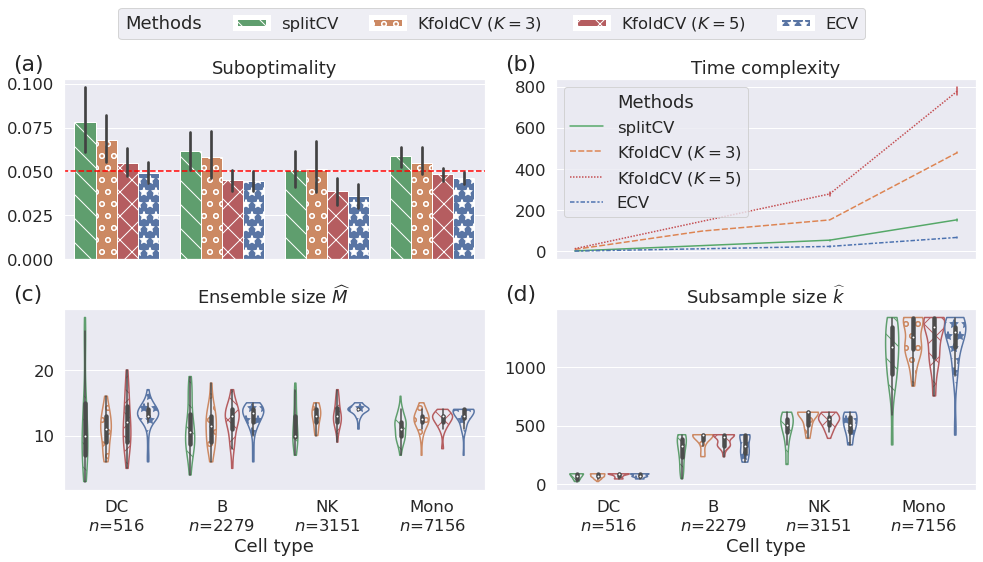

In [24]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(2,2,figsize=(14,8))
delta = 0.05
hue_order=['splitCV','KfoldCV ($K=3$)','KfoldCV ($K=5$)','ECV']
cmap = [sns.color_palette()[2], sns.color_palette()[1], sns.color_palette()[3], sns.color_palette()[0]]
bar = sns.barplot(
    data=res_cv_all[res_cv_all['delta']==delta], x='xlabels', y='subopt', 
    hue='cv_method', hue_order=hue_order, ax=axes[0,0],
    estimator='mean', palette = cmap
)
xlim = axes[0,0].get_xlim()
axes[0,0].hlines(delta, xlim[0]-1, xlim[1]+1, 
               linestyle='--', color='red', zorder=1)
axes[0,0].set_xlim(xlim)
axes[0,0].set_title('Suboptimality')

sns.violinplot(
    data=res_cv_all[(res_cv_all['delta']==delta)&(res_cv_all['k']!=0)], x='xlabels', y='M', cut=0,
    hue='cv_method', hue_order=hue_order, ax=axes[1,0], palette = cmap
)
axes[1,0].set_title('Ensemble size $\widehat{M}$')

sns.violinplot(
    data=res_cv_all[(res_cv_all['delta']==delta)&(res_cv_all['k']!=0)], x='xlabels', y='k', cut=0,
    hue='cv_method', hue_order=hue_order, ax=axes[1,1], palette = cmap
)
axes[1,1].set_title('Subsample size $\widehat{k}$')

sns.lineplot(
    data=df, x='xlabels', hue='cv_method', y='time',
    estimator='mean', err_style='bars', hue_order=hue_order, 
    style='cv_method', style_order=hue_order, 
    ax=axes[0,1], palette = cmap, sort= False)


# Add hatches
hatches = [ '\\', 'o', 'x', '*']
for i,thisbar in enumerate(bar.patches):
    thisbar.set_hatch(hatches[i//4])

for j in range(2):
    ihatch = iter(np.tile(hatches,4))
    for i in axes[i_row,j].get_children():
        if isinstance(i, matplotlib.collections.PolyCollection):
            i.set_edgecolor(i.get_facecolor())
            i.set_facecolor('none')
            i.set_hatch(next(ihatch))

for i in range(2):
    for j in range(2):
        if i==1:
            xlabel = 'Cell type'
        else:
            axes[i,j].set_xticks([])
            xlabel = ''
        axes[i,j].set_xlabel(xlabel)
        axes[i,j].set_ylabel('')
axes[0,1].set_title('Time complexity')

num = ['(a)', '(b)', '(c)', '(d)']
for i in range(2):
    for j in range(2):
        axes[i,j].text(-.12, 1.05, num[int(i*2+j)], 
                     size=22, transform=axes[i,j].transAxes)

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]


for i in range(2):
    for j in range(2):
        if i==0 and j==1:
            axes[0,1].get_legend().set_title('Methods')
            continue
        axes[i,j].get_legend().remove()

legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=5, title='Methods')
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    item.set_linewidth(5)
    label.set_ha('left')
    
plt.tight_layout()
fig.subplots_adjust(top=0.86)
plt.savefig('result/real_data_overview_bs.pdf',
            bbox_inches='tight', pad_inches=0, dpi=300,)

## Figure 8 bagging

In [25]:
res_cv_all = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex5/{}/bagging/{}/'.format(celltype,method)

    res_cv = []
    cv_method_dict = {
        'splitcv':'splitCV', 
        'kfoldcv_3':'3foldCV',
        'kfoldcv_5':'5foldCV',
        'oobcv_50':'ECV',
        'oobcv_100':'ECV-100',
        'oobcv_250':'ECV-250'
    }

    for j,ADT_name in enumerate(ADT_names):
        for i in range(5):
            file_name = path_result + 'res_ADT_{}_test_{}.csv'.format(j, i)
            _df = pd.read_csv(file_name, index_col=0).sort_values('k_list')
            if i==0:
                df = _df
            else:
                df.loc[:,df.columns.str.startswith('test')] += _df.loc[:,df.columns.str.startswith('test')]
        df.loc[:,df.columns.str.startswith('test')] /= 5
        null_risk_test = df.loc[df['k_list']==0,df.columns.str.startswith('test')].mean().mean()
        res_test = df.loc[:,df.columns.str.startswith('test')].values
        res_test = res_test/null_risk_test
        k_hat = np.unique(df['k_list'].values)
        
        for cv_method in [
            'splitcv', 'kfoldcv_3', 'kfoldcv_5', 'oobcv_50', 'oobcv_100', 'oobcv_250']:
            file_name = path_result + 'res_ADT_{}_{}.csv'.format(j, cv_method.split('-')[0])
            df = pd.read_csv(file_name, index_col=0)
            df = df.sort_values('k_list')

            if cv_method=='splitcv':
                null_risk = df.loc[df['k_list']==0,df.columns.str.startswith('test')].mean().mean()
            if cv_method in ['kfoldcv']:
                df.loc[df['k_list']==0,df.columns.str.startswith('test')] = null_risk
            if cv_method.startswith('oobcv'):
                df = df[df['k_list'].isin(k_hat)]

            for M_max in np.arange(1, 51):
                res_val = df.loc[:,df.columns.str.startswith('val')].values
                if cv_method in ['oobcv_100','oobcv_250']:
                    pass
                else:
                    res_val[:,M_max:] = np.inf

                res_cv.append([
                    ADT_name,
                    M_max,
                    cv_method_dict[cv_method], 
                    res_test[np.unravel_index(np.argmin(res_val, axis=None), res_val.shape)]
                ])
    res_cv = pd.DataFrame(res_cv, columns=['ADT_name', 'M_max', 'cv_method', 'NMSE'])
    res_cv['celltype'] = celltype
    res_cv_all = pd.concat([res_cv_all, res_cv], axis=0)

cv_method_dict = {
    'splitcv':'splitCV', 
    'kfoldcv-3':'3foldCV',
    'kfoldcv-5':'5foldCV',
    'oobcv-50':'ECV-50',
    'oobcv-100':'ECV-100',
    'oobcv-250':'ECV-250',
}

df = pd.DataFrame()
for celltype in cell_types_list:
    path_result = 'result/ex5/{}/bagging/{}/'.format(celltype,method)

    res_cv = []
    _df = pd.read_csv(path_result+'res_time_{}.csv'.format(method), index_col=0)
    _df = pd.melt(_df, id_vars=['ADT_name'], value_vars=[
        'splitcv', 'kfoldcv-3','kfoldcv-5','oobcv-50','oobcv-100','oobcv-250',
    ], var_name='cv_method', value_name='time')
    _df['cv_method'] = _df['cv_method'].apply(lambda x:cv_method_dict[x])
    _df['celltype'] = celltype
    df = pd.concat([df, _df], axis=0)

array(['splitCV', '3foldCV', '5foldCV', 'ECV-50', 'ECV-100', 'ECV-250'],
      dtype=object)

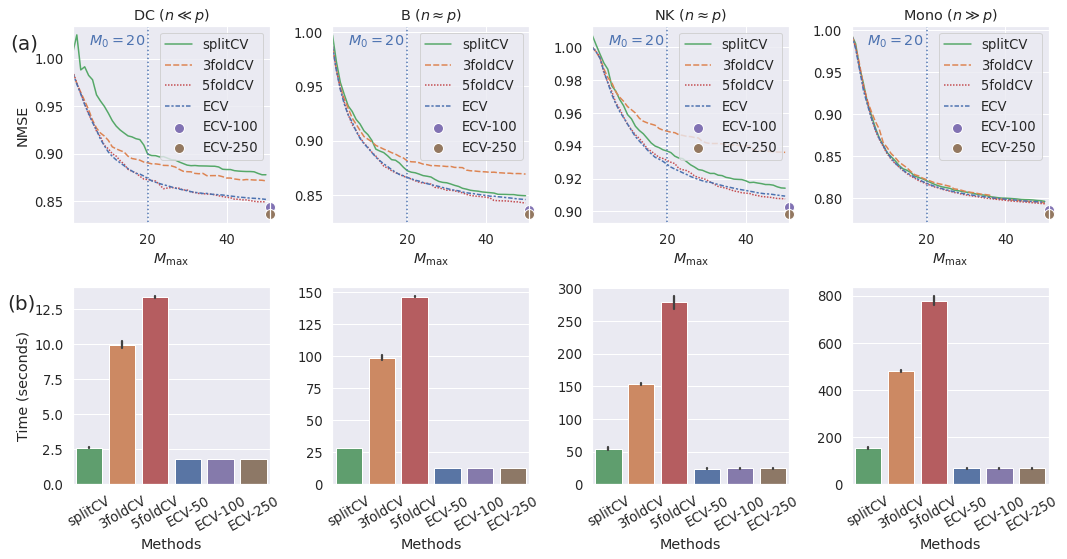

In [27]:
sns.set(font_scale=1.2)
fig, axes = plt.subplots(2,4,figsize=(15,8), sharex='row')
dim_dict = {
    'DC':r'($n\ll p$)', 'B':r'($n\approx p$)', 'NK':r'($n\approx p$)', 'Mono':r'($n\gg p$)'
}
hue_order=['splitCV', '3foldCV', '5foldCV', 'ECV']
for j in range(4):
    celltype = cell_types_list[j]
    i = 0
    sns.lineplot(
        data=res_cv_all[
            (res_cv_all['celltype']==celltype)&
            (~res_cv_all['cv_method'].isin(['ECV-100','ECV-250']))
        ], x='M_max', y='NMSE', estimator='mean', errorbar=None,
        hue='cv_method', hue_order=hue_order, style='cv_method', style_order=hue_order,
        palette = [sns.color_palette()[k] for k in [2,1,3,0]],
        ax=axes[i,j]
    )
    for iM,M in enumerate([100,250]):
        axes[i,j].scatter(
            51,
            res_cv_all[
                (res_cv_all['celltype']==celltype)&
                (res_cv_all['cv_method'].isin(['ECV-{}'.format(M)]))&
                (res_cv_all['M_max']==50)]['NMSE'].mean(), clip_on=False,
            marker='o', s=100, color=sns.color_palette()[4+iM], edgecolor='white', linewidth=1,
            label='ECV-{}'.format(M))
    ylim = axes[i,j].get_ylim()
    axes[i,j].vlines(20, ylim[0]-1, ylim[1]+1, color=sns.color_palette()[0], ls=':')
    axes[i,j].text(5, ylim[0]+(ylim[1]-ylim[0])*0.9, '$M_0=20$', color=sns.color_palette()[0])
    axes[i,j].set_ylim(ylim)
    axes[i,j].legend()
    axes[i,j].set_title(celltype + ' ' + dim_dict[celltype])
    axes[i,j].set_xlim([1,51])
    axes[i,j].set_xlabel('$M_{\max}$')
    
    if j!=0:
        axes[i,j].set_ylabel('')
        
    i = 1
    sns.barplot(data=df[df['celltype']==celltype], palette = [sns.color_palette()[k] for k in [2,1,3,0,4,5]],
                x='cv_method', y='time', estimator='mean', ax=axes[i,j])
    
    if i==0:
        axes[i,j].set_xlabel('')
    else:
        axes[i,j].set_xlabel('Methods')
        axes[i,j].set_xticklabels(
            df['cv_method'].unique(), rotation=30,
        )
        
    if j==0:
        axes[i,j].set_ylabel('Time (seconds)')
    else:
        axes[i,j].set_ylabel('')
        
axes[0,0].text(-15., 1.01, '(a)', fontsize=20)
axes[1,0].text(-2.5, 12.5, '(b)', fontsize=20)
plt.tight_layout()
plt.savefig('result/real_data_{}_bs.pdf'.format(method),
            bbox_inches='tight', pad_inches=0, dpi=300,)

# Package information

Package for visualization in this notebook:

In [28]:
print(
    '\n'.join(np.unique([f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)]))
)

h5py==3.1.0
json==2.0.9
matplotlib==3.5.2
numpy==1.24.1
pandas==1.3.3
scipy==1.10.0
seaborn==0.12.1


Package for running the Python scripts:

In [29]:
!conda list -n base -f "python|os|sys|numpy|scipy|pandas|scikit-learn|h5py"


# packages in environment at /home/jinhongd/anaconda3:
#
# Name                    Version                   Build  Channel
blosc                     1.21.0               h8c45485_0  
h5py                      2.10.0           py38h7918eee_0  
nose                      1.3.7           pyhd3eb1b0_1006  
numpy                     1.20.1           py38h93e21f0_0  
numpy-base                1.20.1           py38h7d8b39e_0  
numpydoc                  1.1.0              pyhd3eb1b0_1  
pandas                    1.2.4            py38h2531618_0  
pycosat                   0.6.3            py38h7b6447c_1  
python                    3.8.8                hdb3f193_5  
python-dateutil           2.8.1              pyhd3eb1b0_0  
python-jsonrpc-server     0.4.0                      py_0  
python-language-server    0.36.2             pyhd3eb1b0_0  
python-libarchive-c       2.9                pyhd3eb1b0_1  
python_abi                3.8                      2_cp38    conda-forge
scikit-learn           